<img src = "../../Data/bgsedsc_0.jpg">

# Project: Decision trees and ensembles


## Programming project: length of stay

In this project, you have to predict the length of stay (in days) of a patient that is entering an ICU (Intensive Care Unit) using decision tree models.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column *LOS* is the length of stay of this patient, equal to discharge time minus admit time.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.
Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as *HOSPITAL_EXPIRE_FLAG*

As performance metric, please use *RMSE* (root mean squared error).

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *LOS* .
+ For this analysis there is an extra test dataset, *mimic_test_los.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_los_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different decision trees algorithms, even combine with other prediction models.  Try to assess which features are more important, and if possible the confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorical features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Predict on the test file, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset. Submit to Kaggle to check performance.

For the in-class assignment, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for grading (In-class)
From more to less important:
+ Decision Trees method(s) have been used
+ Data preparation
+ Code runs
+ Length of stay for each test patient is computed
+ Accuracy of predictions for test patients is evaluated (Kaggle)
+ Accuracy itself
+ Hyperparameter optimization


## Main criteria for grading (Extended)
From more to less important:
+ Decision Trees method(s) have been used
+ Data preparation
+ Length of stay for each test patient is computed
+ Accuracy of predictions for test patients is evaluated (Kaggle)
+ Accuracy itself
+ Hyperparameter optimization
+ Neat and understandable code, with some titles and comments
+ Improved methods from what we discussed in class (properly explained/justified)
+ Code runs

# Google Colab

Just run this cell if running from Google Colab, to set the correct working directory

In [ ]:
from google.colab import drive
import os
# Mount google drive if running from Google Collab
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/bgse-k-nn-death') ## Google Colab

# INTRO: Modules and work directory


We import all the modules that will be used throughout the code and we set the local working directory from which we will get the data.

In [ ]:
import os
## Work directory

## Set current directory either from Google Colab or local
os.chdir('/Users/yersivillegas/Desktop/TERM 1/CML/PROJECTS/b-gse-dt-los') ## Local
#os.chdir('/Volumes/GoogleDrive/Mi unidad/bgse-k-nn-death') ## Local through Drive

In [ ]:
#import auxiliar functions
import sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import *

## Basic python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import datetime as dt
from datetime import timedelta

## Modules for feature engineering 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, RobustScaler, KBinsDiscretizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA, IncrementalPCA
from category_encoders.binary import BinaryEncoder
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.linear_model import SGDRegressor

## Modules for constructing Pipelines
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


## Modules to run our models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest, ExtraTreesRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

## Modules to check accuracy of our models
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import datasets, metrics, model_selection
from sklearn.model_selection import cross_val_predict

## Modules for ensembles
from mlens.visualization import corrmat
from mlens.model_selection import Evaluator
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble
from mlens.metrics import make_scorer
from sklearn.svm import SVR

# MANAGING DATA (RUN)


## Loading and dropping useless data

We load all datasets from the beginning: training, test and extra data. Furthermore, we can already drop the columns of the variables that we didn't know when the patient entered the hospital: 

 - _DOD_
 - _HOSPITAL EXPIRE FLAG_
 - _DISCHTIME_
 - _DEATHTIME_

Moreover, since _DIAGNOSIS_ is a free-text column, we cannot get useful data from it and therefore, we can also drop it.

In [ ]:
# Training dataset:
data=pd.read_csv('mimic_train.csv')

# Test dataset (to produce predictions):
data_test=pd.read_csv('mimic_test_los.csv')

# Extra data of all comobirdities:
extra=pd.read_csv('extra_data/MIMIC_diagnoses.csv')

In [ ]:
## We get rid of the columns that are not going to be used.

data=data.drop(['HOSPITAL_EXPIRE_FLAG','DIAGNOSIS'], axis=1)
data_test=data_test.drop(['DIAGNOSIS'], axis=1)


## Dates

Now, we begin by working with the date-type columns of both the training and test datasets.

First, we add the _Diff_ column to the _Date of Birth_ and _ADMITTIME_ column, in order to get reasonable dates, so that we can later extract other values. Then, we compute the age of each patient by substrating the _DOB_ from the _ADMITTIME_. 

In [ ]:
## Changing the columns with dates into datetime variables, 
## taking into account the 'Diff' column that has to be applied to every date.

data['Diff']=data.apply(lambda x: timedelta(days=-x.Diff),axis=1)
data['DOB'] = data.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
data['DOB'] = data.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
data['ADMITTIME'] = data.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
data['ADMITTIME'] = data.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
data['age']=data.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)

In [ ]:
data_test['Diff']=data_test.apply(lambda x: timedelta(days=-x.Diff),axis=1)
data_test['DOB'] = data_test.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
data_test['DOB'] = data_test.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
data_test['ADMITTIME'] = data_test.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
data_test['ADMITTIME'] = data_test.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
data_test['age']=data_test.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)

Now, we can extract the hour, day, month and year in which each patient entered the hospital. Furthermore, we create three more categorical variables with these date-related data: 
- Whether the patient entered the hospital during the night; from 10PM to 6AM. 
- The season in which each patient entered the hospital:
  - Winter: from december to february
  - Spring: from march to may
  - Summer: from june to august
  - Autumn: from september to november
- Whether the patient entered the hospital in one of the main nine holidays in the USA:
  - New Year's day (January 1st)
  - Martin Luther King Jr. Day (January 18th)
  - Memorial Day (May 31st)
  - Independence Day (July 5th)
  - Labor Day (September (6th)
  - Veterans Day (November 11th)
  - Thanksgiving (November 25th)
  - Christmas Day (December 24th)
  - New Year's Eve (December 31st) 



In [ ]:
## Computing year, month, day and hour of entry,
## along with categorical binary-type night-time entry.
data['day'] = data['ADMITTIME'].apply(lambda x: x.day)
data['month'] = data['ADMITTIME'].apply(lambda x: x.month)
data['year'] = data['ADMITTIME'].apply(lambda x: x.year)
data['hour'] = data['ADMITTIME'].apply(lambda x: x.hour)
data_test['day'] = data['ADMITTIME'].apply(lambda x: x.day)
data_test['month'] = data_test['ADMITTIME'].apply(lambda x: x.month)
data_test['year'] = data_test['ADMITTIME'].apply(lambda x: x.year)
data_test['hour'] = data_test['ADMITTIME'].apply(lambda x: x.hour)
data['time_entrance']=np.where((data['hour'] > 22) | (data['hour'] < 6) , 'night', 'day')
data_test['time_entrance']=np.where((data_test['hour'] > 22) | (data_test['hour'] < 6) , 'night', 'day')



In [ ]:
## Computing season of the year
data['season'] = np.where((data['month'] > 11) | (data['month'] < 3) , 'winter', 'autumn')
data['season'] = np.where((data['month'] > 2) & (data['month'] < 6) , 'spring', data['season'])
data['season'] = np.where((data['month'] > 5) & (data['month'] < 9) , 'summer', data['season'])
data_test['season'] = np.where((data_test['month'] > 11) | (data_test['month'] < 3) , 'winter', 'autumn')
data_test['season'] = np.where((data_test['month'] > 2) & (data_test['month'] < 6) , 'spring', data_test['season'])
data_test['season'] = np.where((data_test['month'] > 5) & (data_test['month'] < 9) , 'summer', data_test['season'])


In [ ]:
## Adding feature to see if it was a holiday in USA
data['type_of_day']=np.where((data['month'] == 1) & (data['day'] == 1) |
                         (data['month'] == 1) & (data['day'] == 18) | 
                         (data['month'] == 5) & (data['day'] == 31) |
                         (data['month'] == 7) & (data['day'] == 5) | 
                         (data['month'] == 9) & (data['day'] == 6) |
                         (data['month'] == 11) & (data['day'] == 11) | 
                         (data['month'] == 11) & (data['day'] == 25) |
                         (data['month'] == 12) & (data['day'] == 24) |  
                         (data['month'] == 12) & (data['day'] == 31) , 'holiday', 'regular')

data_test['type_of_day']=np.where((data_test['month'] == 1) & (data_test['day'] == 1) |
                         (data_test['month'] == 1) & (data_test['day'] == 18) | 
                         (data_test['month'] == 5) & (data_test['day'] == 31) |
                         (data_test['month'] == 7) & (data_test['day'] == 5) | 
                         (data_test['month'] == 9) & (data_test['day'] == 6) |
                         (data_test['month'] == 11) & (data_test['day'] == 11) | 
                         (data_test['month'] == 11) & (data_test['day'] == 25) |
                         (data_test['month'] == 12) & (data_test['day'] == 24) |  
                         (data_test['month'] == 12) & (data_test['day'] == 31) , 'holiday', 'regular')


In [ ]:
# Checking it works
data[(data['month'] == 1) & (data['day'] == 18)]['type_of_day'].head()

105     holiday
928     holiday
1139    holiday
1330    holiday
2331    holiday
Name: type_of_day, dtype: object

Now, we create a new categorical value, which represents the age range to which each patient belongs to:
- Under 30 years
- Between 30 and 60 years
- Over 60 years

In [ ]:
## Computing age range

data['age_inf']=np.where(data['age'] < 11000, 'under_30', '30_to_60')
data['age_inf']=np.where(data['age'] >= 22000, 'over_60', data['age_inf'])
data_test['age_inf']=np.where(data_test['age'] < 11000, 'under_30', '30_to_60')
data_test['age_inf']=np.where(data_test['age'] >= 22000, 'over_60', data_test['age_inf'])
date_related_cols=['year','month','day','hour','time_entrance','season', 'type_of_day','age_inf']

Finally, we can already drop the date-type columns, since we have already extracted the useful data from them. For those binary features we have now created, the reason we haven't directly used 1s or 0s instead of two unique strings is because the encoder we will later use, which will be _BinaryEncoder_. Since this encoder will write all categorical variables in a bit-string format of 1s and 0s, instead of creating dummies with many columns, we use a unified criterion and treat all categorical values equally. It may not change if we just used 1s and 0s for these binary date-related features, but it is more coherent to keep the same criterion.

In [ ]:
## We get rid of the columns that are not going to be used anymore.

data=data.drop(['DOB','ADMITTIME','Diff'], axis=1)
data_test=data_test.drop(['DOB','ADMITTIME','Diff'], axis=1)

## Adding the extra data and other features

The data we have been working with only contained the diagnosis that got the patient into the hospital. However, each patient may have many other extra diagnosis, which are stored in the extra data. For this project, we will not completely use all the extra data, since we would have the same problem we will see in the upcoming _NOT INCLUDED_ section: _LOS_ is a continuous variable, therefore not making sense to compute a target encoding over it. Hence, we will just add a portion of the extra data, as we will now explain.

This is the only part of the extra data that will be used. We can also compute the number of comoborbidities a patient had for each _HADM ID_; that is, for each stay in the hospital. We count the number of times each _HADM ID_ appears in the extra data and we add it to both training and test set.

In [ ]:
## Number of comorbidites in each hospital stay

num_of_comob=extra['HADM_ID'].value_counts()
data['num_of_comob']=data['hadm_id'].replace(to_replace=num_of_comob.index,value=num_of_comob.values)
data_test['num_of_comob']=data_test['hadm_id'].replace(to_replace=num_of_comob.index,value=num_of_comob.values)

Moreover, we add the following features. First, we will add a column for those patients that had, at least, one missing value, in order to use missingness as a feature itself, since it could mean that the patient did not stay long enough or that he died. For the same reason as before, even though it is a binary variable, we will use two unique strings instead of directly using 1s and 0s, in order to encode all the non-numerical variables in the same way (with _BinaryEncoder_).

In [ ]:
## Checking if there is any null value in any column
data['patient_with_missing_info'] = data.apply(lambda x: 'Yes' if any(x.isnull()[list(data.columns)]) else 'No',axis=1)
data_test['patient_with_missing_info'] = data_test.apply(lambda x: 'Yes' if any(x.isnull()[list(data_test.columns)]) else 'No',axis=1)

In [ ]:
# We check it is correctly computed
pd.set_option('display.max_columns', None)
data[data['patient_with_missing_info'] == 'Yes'].head()

subject_id  hadm_id  icustay_id  HeartRate_Min  HeartRate_Max  \
4        28424   127337      225281            NaN            NaN   
17       53782   190648      246339           72.0          100.0   
19       28939   171688      274823            NaN            NaN   
24       32122   121433      298281            NaN            NaN   
32       54509   179708      283176           97.0          138.0   

    HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  DiasBP_Max  \
4              NaN        NaN        NaN         NaN         NaN         NaN   
17       88.555556       81.0      150.0  101.428571        47.0        69.0   
19             NaN        NaN        NaN         NaN         NaN         NaN   
24             NaN        NaN        NaN         NaN         NaN         NaN   
32      117.571429       87.0      165.0  113.955882        46.0        99.0   

    DiasBP_Mean  MeanBP_Min  MeanBP_Max  MeanBP_Mean  RespRate_Min  \
4           NaN         NaN         NaN          NaN           NaN   
17    53.936508        52.0        93.0    67.031746          10.0   
19          NaN         NaN         NaN          NaN           NaN   
24          NaN         NaN         NaN          NaN           NaN   
32    63.676471        61.0       112.0    79.161765          12.0   

    RespRate_Max  RespRate_Mean  TempC_Min  TempC_Max  TempC_Mean  SpO2_Min  \
4            NaN            NaN        NaN        NaN         NaN       NaN   
17          36.0      16.602941        NaN        NaN         NaN      94.0   
19           NaN            NaN        NaN        NaN         NaN       NaN   
24           NaN            NaN        NaN        NaN         NaN       NaN   
32          33.0      19.600000  36.055556  39.611111   38.463889      85.0   

    SpO2_Max  SpO2_Mean  Glucose_Min  Glucose_Max  Glucose_Mean GENDER  \
4        NaN        NaN         97.0        137.0    113.000000      F   
17     100.0  99.089286         62.0        164.0    112.700000      M   
19       NaN        NaN        131.0        204.0    167.500000      F   
24       NaN        NaN        127.0        228.0    167.600000      M   
32     100.0  98.285714         93.0        117.0    103.090909      M   

   ADMISSION_TYPE INSURANCE           RELIGION MARITAL_STATUS  \
4       EMERGENCY  Medicare             JEWISH        WIDOWED   
17      EMERGENCY  Medicare           CATHOLIC         SINGLE   
19       ELECTIVE  Medicare  PROTESTANT QUAKER         SINGLE   
24      EMERGENCY  Medicare      NOT SPECIFIED         SINGLE   
32      EMERGENCY  Medicaid       UNOBTAINABLE            NaN   

                 ETHNICITY ICD9_diagnosis FIRST_CAREUNIT     LOS    age  day  \
4                    WHITE          56211          TSICU  5.8654  28990   12   
17                   WHITE          41401           CSRU  4.9430  30378   31   
19  BLACK/AFRICAN AMERICAN           1508          TSICU  2.9421  25236   17   
24                   WHITE           5849            CCU  3.1598  26487   30   
32   UNKNOWN/NOT SPECIFIED          86405          TSICU  5.6952  12959   26   

    month  year  hour time_entrance  season type_of_day   age_inf  \
4       9  2008     7           day  autumn     regular   over_60   
17      3  2010     5         night  spring     regular   over_60   
19      2  2008     2         night  winter     regular   over_60   
24     10  2008    16           day  autumn     regular   over_60   
32      3  2010     5         night  spring     regular  30_to_60   

    num_of_comob patient_with_missing_info  
4             16                       Yes  
17            13                       Yes  
19             9                       Yes  
24            10                       Yes  
32            20                       Yes

Finally, we compute another binary-categorical variable in order to know if a patient has been more than once in the ICU and/or in the Hospital.

In [ ]:
## Feature to know if if a patient has been more than once in ICU and/or hospital
data['times_in_ICU'] = np.where(data.duplicated(subset=['hadm_id']),'Once','More_than_once')
data['times_in_Hospital'] = np.where(data.duplicated(subset=['subject_id']),'Once','More_than_once')
data_test['times_in_ICU'] = np.where(data_test.duplicated(subset=['hadm_id']),'Once','More_than_once')
data_test['times_in_Hospital'] = np.where(data_test.duplicated(subset=['subject_id']),'Once','More_than_once')

## Training sets

When we are done with working with our data, we will get rid of the identifier variables, since they will no longer be useful (they are just id's), and we can then drop the target variable (_LOS_) we are going to predict, in order to create the training _X_ and _y_ sets. Also, while removing the _icustay id_, we will set it as the index of our data.

In [ ]:
data.set_index('icustay_id', inplace = True)
data_test.set_index('icustay_id', inplace = True)
data=data.drop(['subject_id', 'hadm_id'], axis=1)
data_test=data_test.drop(['subject_id', 'hadm_id'], axis=1)

In [ ]:
X_train = data.drop(['LOS'], axis=1) 
y_train = data["LOS"] 

# MANAGING DATA (not included but we show the done work)

This group of cells correspond to the part of the code which has not been run for this project. Here, we explain the reason why we do not include it and we show the done work. The code has been commented out (with a #### that identifies the part that was code), in case it gets accidentally run, so that it does not affect the rest of the project


## Extra data

Here, we firstly merge our training data with the extra data by the _HADM ID_ columns, so that we can associate all the extra _ICD9 codes_ to the _LOS_ of each patient. Then, we would change each _ICD9 code_ with its associated _LOS_ mean, and we would do it for all datasets: training, test and merged. However, since _LOS_ is a continuous variable, this kind of target encoding would not be suitable; instead, in order to deal with these computed means of the continuos _LOS_ variable, we could discretize it into _k_ different groups of values. Let's see the steps we have done:

First, we obtain the aforementioned.

In [ ]:
## Merging and computing LOS mean for the diagnosis

# COMMENTED-OUT IN CASE IT GETS ACCIDENTALLY RUN
####alldata = pd.merge(data,extra,how='left',left_on='hadm_id',right_on='HADM_ID')

In [ ]:
## Discretizer function
def cont_var_discretizer(train,test,columns):
  discretizer = KBinsDiscretizer(encode='ordinal',strategy='kmeans')
  for col in columns:
    train[col]=discretizer.fit_transform(train[[col]])
    test[col]=discretizer.transform(test[[col]])
    train[col]=train[col].astype('object',copy=False)
    test[col]=test[col].astype('object',copy=False)

In [ ]:
# COMMENTED-OUT IN CASE IT GETS ACCIDENTALLY RUN

####diag_mean = alldata.groupby('ICD9_CODE').mean()['LOS']


####data['ICD9_diagnosis_mean_LOS']=data['ICD9_diagnosis'].replace(to_replace=diag_mean.index,value=diag_mean.values) #_mean
####data_test['ICD9_diagnosis_mean_LOS']=data_test['ICD9_diagnosis'].replace(to_replace=diag_mean.index,value=diag_mean.values) #_mean
####data_test['ICD9_diagnosis_mean_LOS']=pd.to_numeric(data_test['ICD9_diagnosis_mean_LOS']) #_mean

In [ ]:
# COMMENTED-OUT IN CASE IT GETS ACCIDENTALLY RUN
####alldata['ICD9_CODE']=alldata['ICD9_CODE'].replace(to_replace=diag_mean.index,value=diag_mean.values)

Now, once we have changed the _ICD9 code_ for their associated death rate, we would repeat the procedure and now compute the following: for each _HADM ID_, we would compute the _LOS_ mean corresponding to the mean of means of all the diagnosis that patient had in that hospital stay. Furthermore, we could also compute the maximum and minimum _LOS_ mean; meaning, the diagnose that had the highest and lowerst _LOS_ mean, respectively. Thus, we would add these three columns:
- _mean of means_ 
- _max of means_
- _min of means_

to both training and test set. In the test set, for those _HADM ID_ which did not appear in the training set, we would change it for the mean value of that column. Then, as we did before, we discretized these columns in order to be correct to use them.

However, since target encoding is not a good criterion for a continuous variable, even though we could discretize it, it does not seem right to compute "two" target encodings (first, the _ICD9 code_ mean and then, the corresponding mean/max/min of means). Therefore, we completely discard to use those variables. Then, in order to know whether to include the _ICD9 code_ discretized mean, we tried them both and kept whatever yielded better results. Hence, we decided not to include it in the final version of the project, since it did not improve the results.

In [ ]:
# COMMENTED-OUT IN CASE IT GETS ACCIDENTALLY RUN

## Mean() and max() of the LOS mean for each diagnosis
## that a patient has in each stay

####mean_of_means=alldata.groupby('HADM_ID').mean()['ICD9_CODE']
####max_of_all=alldata.groupby('HADM_ID').max()
####max_of_means=max_of_all['ICD9_CODE']

In [ ]:

####data['mean_of_means']=data['hadm_id'].replace(to_replace=mean_of_means.index,value=mean_of_means.values)
####data_test['mean_of_means']=data_test['hadm_id'].replace(to_replace=mean_of_means.index,value=mean_of_means.values)
####data_test['mean_of_means']=np.where(data_test['mean_of_means'] > mean_of_means.max(), mean_of_means.mean(), data_test['mean_of_means'])

In [ ]:

####data['max_of_means']=data['hadm_id'].replace(to_replace=max_of_means.index,value=max_of_means.values)
####data_test['max_of_means']=data_test['hadm_id'].replace(to_replace=max_of_means.index,value=max_of_means.values)
####data_test['max_of_means']=np.where(data_test['max_of_means'] > max_of_means.max(), max_of_means.mean(), data_test['max_of_means'])

In [ ]:
####min_of_all=alldata.groupby('HADM_ID').min()
####min_of_means=min_of_all['ICD9_CODE']

In [ ]:
####data['min_of_means']=data['hadm_id'].replace(to_replace=min_of_means.index,value=min_of_means.values)
####data_test['min_of_means']=data_test['hadm_id'].replace(to_replace=min_of_means.index,value=min_of_means.values)
####data_test['min_of_means']=np.where(data_test['min_of_means'] > min_of_means.max(), min_of_means.mean(), data_test['min_of_means'])

In [ ]:
## Discretizer function applied
####cont_cols = ['ICD9_diagnosis_mean_LOS','mean_of_means''max_of_means','min_of_means']

####cont_var_discretizer(data,data_test,cont_cols)

## Getting useful numerical data from categorical and date-related data

Here, we would get new numerical variables based on the categorical and date-related ones; we would encode these variables and change their non-numerical result for their associated _LOS_ mean. However, exactly as we said before, target encoding would not be suitable for a continuous variable, and even though we could discretize the resutls, we will already encode the catergorical and date-related data with the BinaryEncoder(). 

Hence, there is no need to double-use these variables, so we will not run this block of cells for this project; we just leave the done work.


For each categorical variable, we would compute their mean associated to the _LOS_ value they have. Therefore, we will have a table with each categorical value (indexes) and their _LOS_ mean (values). Hence, we just need to go over the training and the test set and, whenever we find the index, we change it for their corresponding death rate. We will do so in the following columns:
- _GENDER_
- _ADMISSION TYPE_
- _INSURANCE_
- _RELIGION_
- _MARITAL STATUS_
- _ETHNICITY_
- _FIRST CAREUNIT_

In [ ]:
## Function to compute the LOS mean of a variable
## and add a new column to both training and test sets

def LOS_rate_calc(column,target,newcol):
  col_mean=data.groupby(column).mean()[target]
  data[newcol]=data[column].replace(to_replace=col_mean.index,value=col_mean.values)
  data_test[newcol]=data_test[column].replace(to_replace=col_mean.index,value=col_mean.values)

In [ ]:
## Applying LOS mean function to the categoricals

####cat_col=[name for name in data_test.select_dtypes(exclude=np.number).columns]
####cat_col.remove('ICD9_diagnosis')
####for col in cat_col:
  ####LOS_rate_calc(col,'LOS',col+'_mean_LOS')

Finally, we would do the same with the date-related variables we developed before:

In [ ]:
## Applying LOS mean function to the date-related

####for col in date_related_cols:
  ####LOS_rate_calc(col,'LOS',col+'_mean_LOS') 

In [ ]:
####cat_and_date_cols = date_related_cols + cat_col
####cont_var_discretizer(data,data_test,cat_and_date_cols)

# FEATURE ENGINEERING (RUN)


## Checking correlation between features

First, we just plot the correlation matrix as a heatmap, in order to see the features that are correlated with each other. For now, we just have the numerical features. Later on, when we clean and encode our data, we will further plot the correlation heatmap of all features. Hence, we will later decide what to do with features that are highly correlated between them.

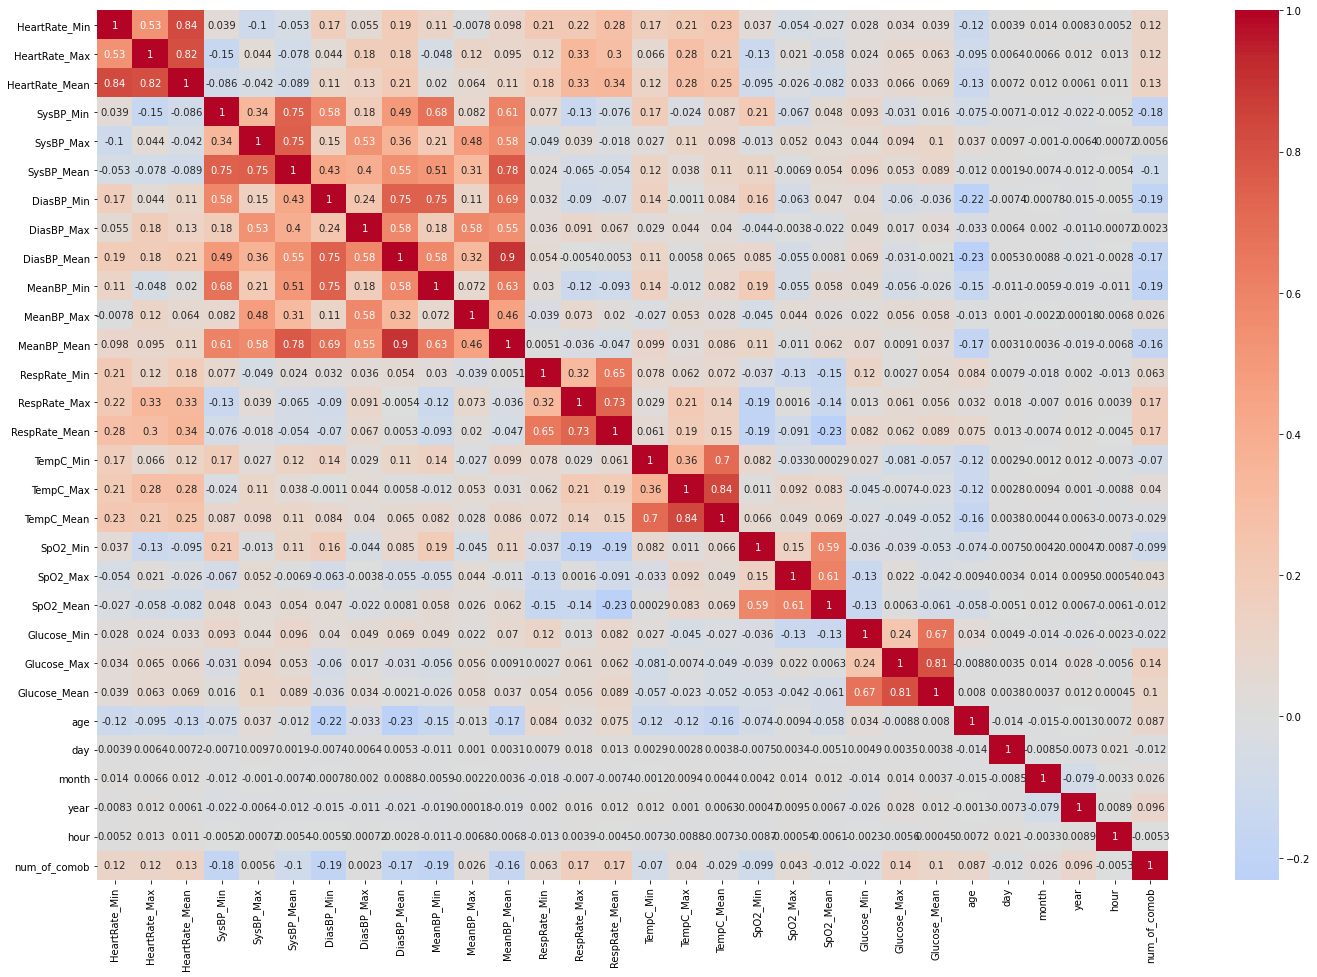

In [ ]:
# We plot the correlation matrix of the features (just takes numericals)
heatmap_corr = X_train.corr()
plt.figure(figsize=(24,16))  
ax=sns.heatmap(heatmap_corr, annot=True, center=0, cmap='coolwarm', xticklabels=True, yticklabels=True)

## Cleaning the data

With all our managed data, we will now deal with all the preprocessing of data required before performing our model. In order to do that, we will put all the methods together with the Pipeline module.

First, for the numerical features, we will first impute all the _NaN_ with the _IterativeImputer_. This imputer changes the _NaN_'s with the mean of the corresponding column. However, it goes through all the features in the data in order to just use the correct observations for each _NaN_. Therefore, it improves the performance of the _SimpleImputer_, which just computes the column mean without taking into account all other features.
Then, we will use the _Standard Scaler_ in order to scale the data, just like we did in class. After having tried other scalers, like the _MinMaxScaler_ or the _RobustScaler_ (robust to outliers), the standard one was the one with the best performance. As we will later see, the reason why the _RobustScaler_ was not better than the _Standard Scaler_ may be due to the few number of outliers of the data.

Then, for the categorical features, we will begin with the _SimpleImputer_, since the _IterativeImputer_ could not handle the object-type features. Then, in order to encode them, we originally worked with encoders that created a very high dimensional data, like the _OneHotEncoder_. However, the _BinaryEncoder_ works in a much efficient way: instead of creating a column for each possible categorical value, it creates a bit-string of 1s and 0s in a sigle column for each categorical feature. In this way, it produces the same information of the _OneHotEncoder_, but in a much more compact form, so that it performs better.


In [ ]:
## We define the Pipelines for both types of features

numeric_transformer = Pipeline(steps=[
       ('imputer', IterativeImputer()),
      ('scaler', StandardScaler())   
])

categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant')),
       ('encoder', BinaryEncoder(drop_invariant=True))
])

Then, we will put the numerical and categorical Pipelines into a _ColumnTransformer_, which applies the different methods in the Pipelines to the corresponding columns (numerical and categorical for each one); we define it as _preprocessor_. We check that the numerical and categorical features are correctly arranged by creating lists with the column names of our data.

In [ ]:
## Define lists with the numerical and categorical values separately

num_feat=[name for name in data_test.select_dtypes(include=np.number).columns]
cat_feat=[name for name in data_test.select_dtypes(exclude=np.number).columns]

## We define the preprocessor

preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, num_feat),
    ('categorical', categorical_transformer, cat_feat)
]) 

## Define the pipeline with the preprocessor and the regressor
cleaning_pipeline = Pipeline(steps = [('preprocessor', preprocessor)])



In [ ]:
X_train_clean = cleaning_pipeline.fit_transform(X_train)
X_test_clean = cleaning_pipeline.transform(data_test)
print(X_train.shape)
print(X_train_clean.shape)

(20885, 45)
(20885, 81)


## Outlier detection and removal

Here, we define an _IsolationForest_, a decision-trees algorithm that detects outliers inside the data, so we can later remove them. The algorithm return the anomaly score of each sample by ‘isolating’ observations through a random selection of a feature and then, a random selection of a split value between the maximum and minimum values of the selected feature. Since recursive partitioning can be represented by a decision-trees structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies. 

We do a small _GridSearch_ to know the best parameters for the _IsolationForest_ and then, remove them from our data.

In [ ]:
## Define the first regressor 
outlier_detector=IsolationForest(max_samples=0.8,max_features=0.8,bootstrap=True)
param_grid_outlier = {'n_estimators': [100,200],
              'contamination': ['auto', 0.0001, 0.0002]} 

In [ ]:
grid_outliers = GridSearchCV(outlier_detector, param_grid = param_grid_outlier, scoring='neg_root_mean_squared_error', cv=5, verbose=3)
grid_outliers.fit(X_train_clean,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...........contamination=auto, n_estimators=100; total time=   0.7s
[CV 2/5] END ...........contamination=auto, n_estimators=100; total time=   0.7s
[CV 3/5] END ...........contamination=auto, n_estimators=100; total time=   0.6s
[CV 4/5] END ...........contamination=auto, n_estimators=100; total time=   0.7s
[CV 5/5] END ...........contamination=auto, n_estimators=100; total time=   0.7s
[CV 1/5] END ...........contamination=auto, n_estimators=200; total time=   1.3s
[CV 2/5] END ...........contamination=auto, n_estimators=200; total time=   1.3s
[CV 3/5] END ...........contamination=auto, n_estimators=200; total time=   1.3s
[CV 4/5] END ...........contamination=auto, n_estimators=200; total time=   1.4s
[CV 5/5] END ...........contamination=auto, n_estimators=200; total time=   1.3s
[CV 1/5] END .........contamination=0.0001, n_estimators=100; total time=   1.3s
[CV 2/5] END .........contamination=0.0001, n_est

GridSearchCV(cv=5,
             estimator=IsolationForest(bootstrap=True, max_features=0.8,
                                       max_samples=0.8),
             param_grid={'contamination': ['auto', 0.0001, 0.0002],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
grid_outliers.best_params_ 

{'contamination': 0.0001, 'n_estimators': 100}

In [ ]:
outlier_pred = grid_outliers.predict(X_train_clean)
X_train_clean, y_train_clean = X_train_clean[(outlier_pred != -1), :], y_train[(outlier_pred != -1)]
print(X_train_clean.shape, y_train_clean.shape)

(20882, 81) (20882,)


## Removing highly correlated features

First, we can recover the DataFrame format of our data, after all the cleaning steps we have applied, in order to plot the correlation heatmap of all features, as we said before.

In [ ]:
X_train_clean = pd.DataFrame(X_train_clean)
variables = num_feat + preprocessor.transformers_[1][1]['encoder'].get_feature_names()
X_train_clean.columns = variables

X_test_clean = pd.DataFrame(X_test_clean)
variables = num_feat + preprocessor.transformers_[1][1]['encoder'].get_feature_names()
X_test_clean.columns = variables

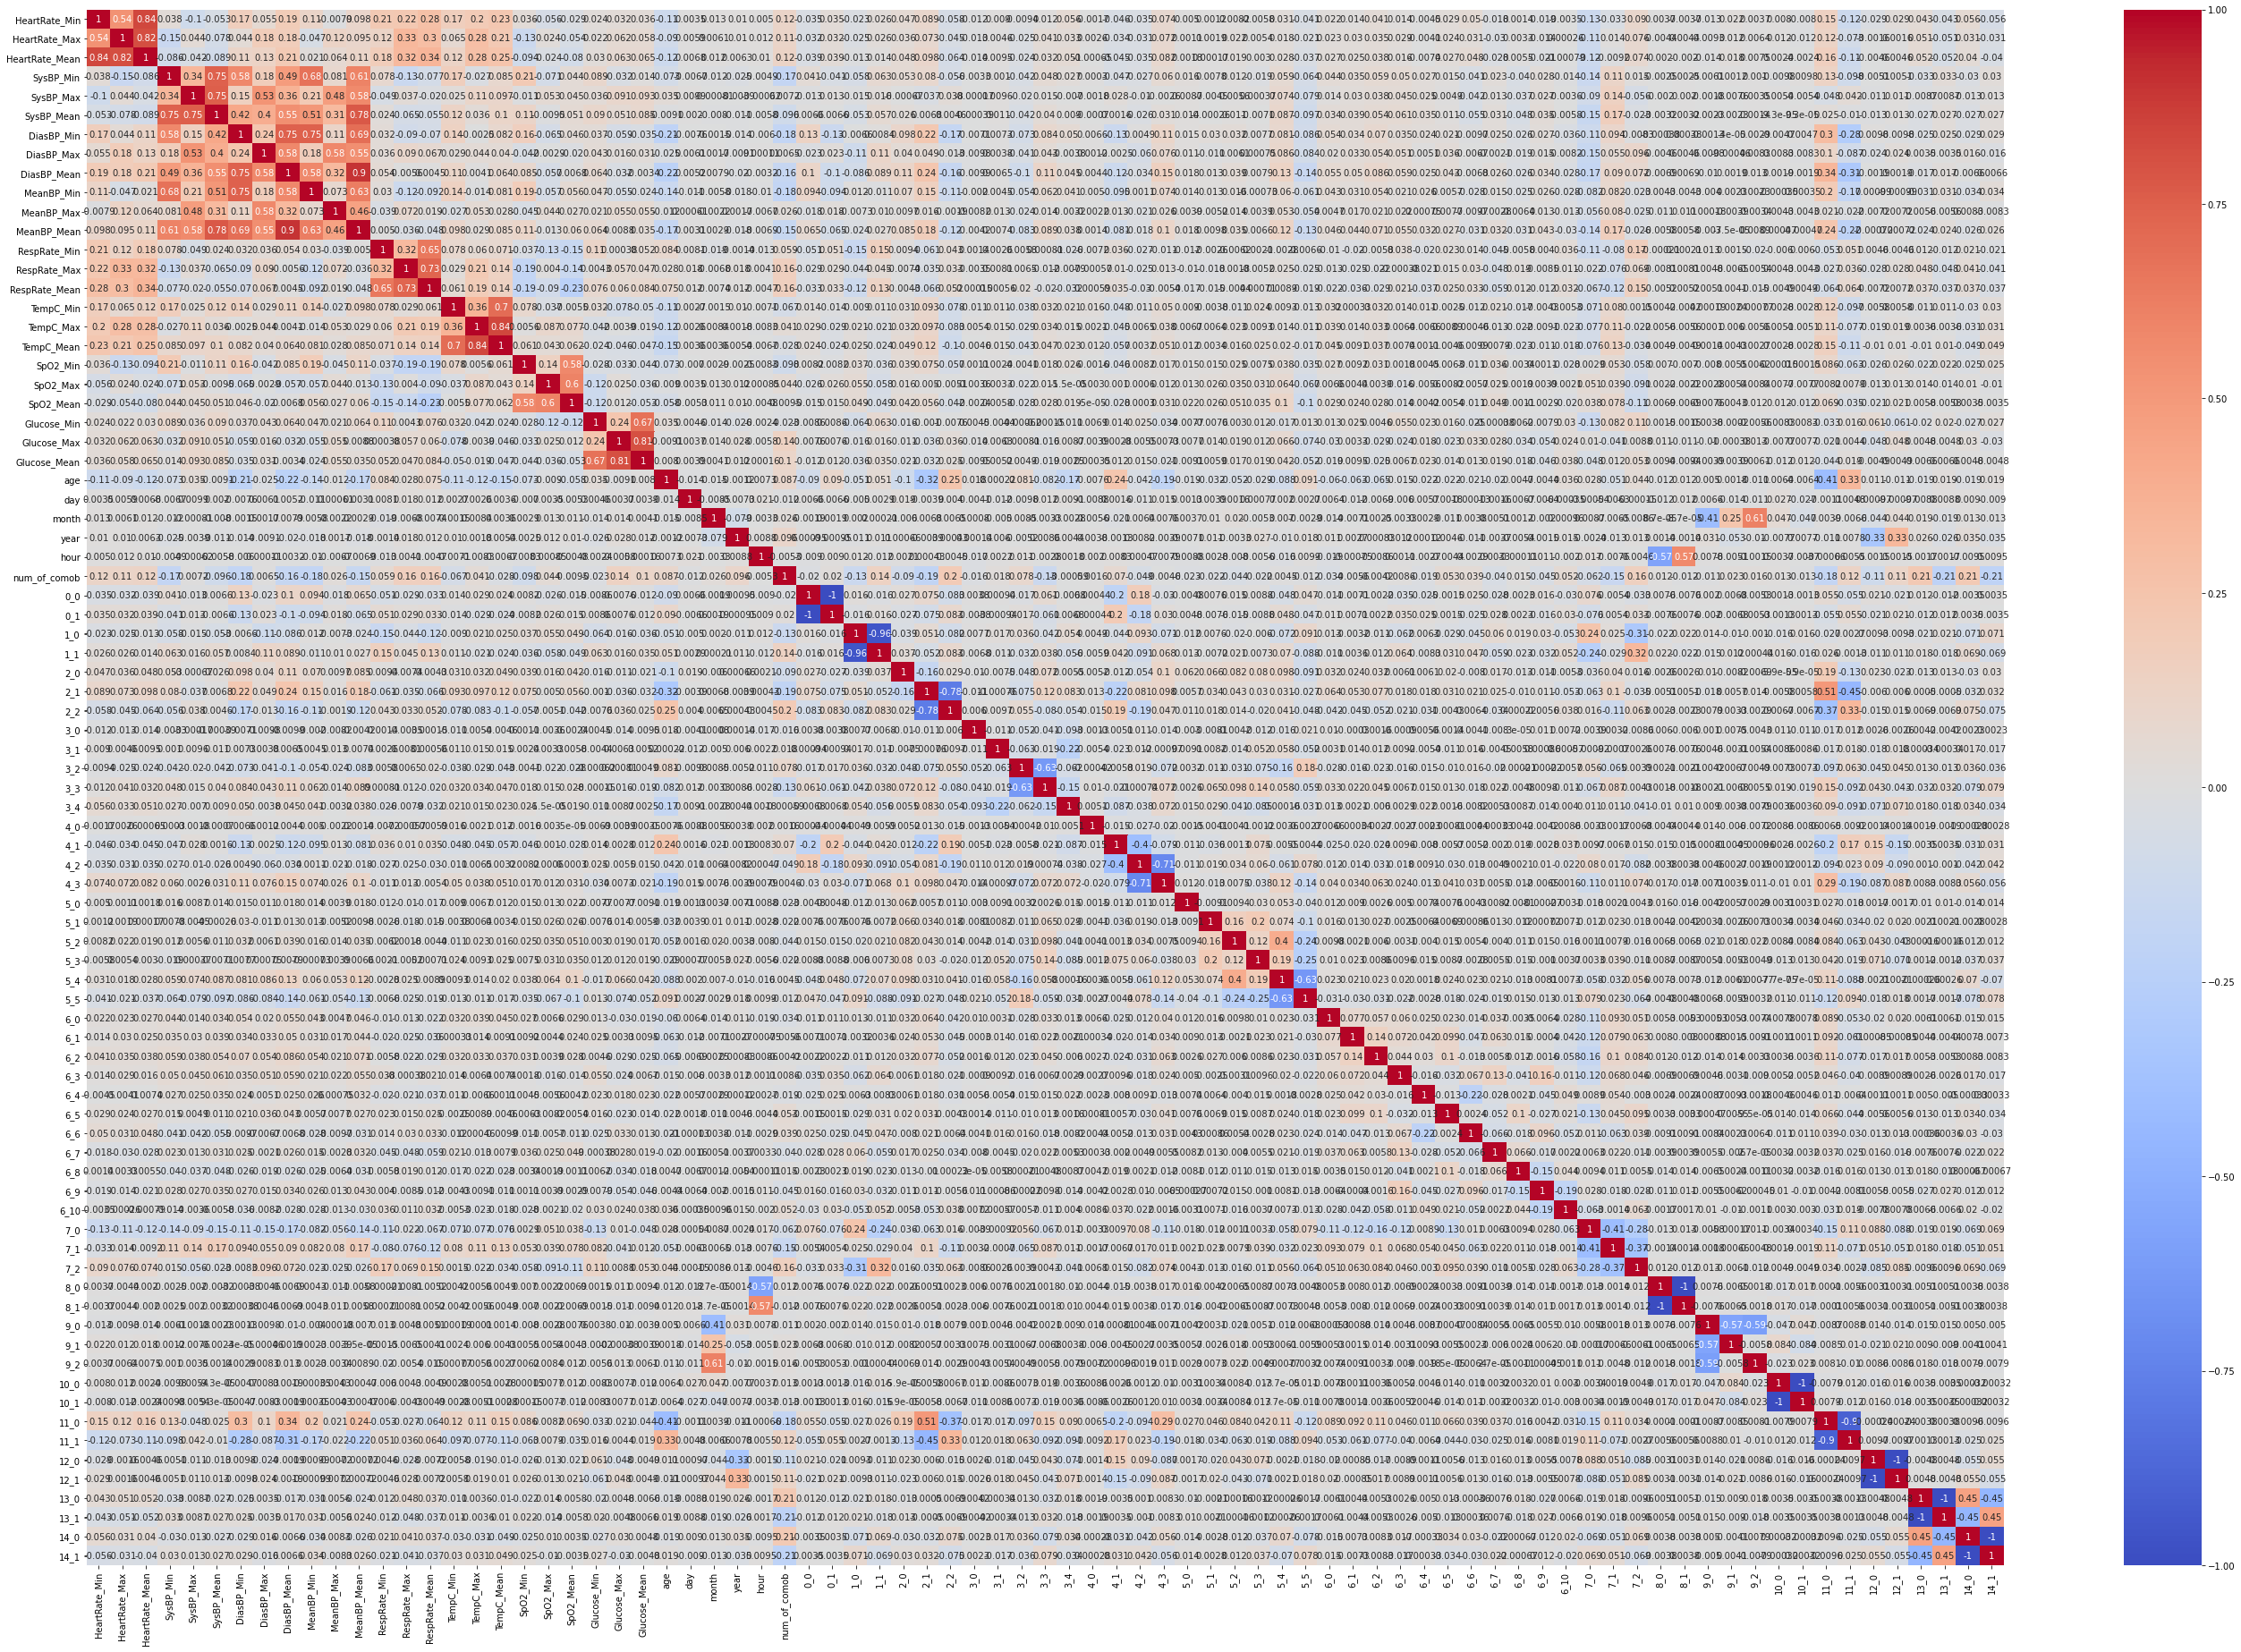

In [ ]:
# Correlation heatmap of all features
heatmap_corr_cleaned = X_train_clean.corr()
plt.figure(figsize=(48,32))  
ax=sns.heatmap(heatmap_corr_cleaned, annot=True, center=0, cmap='coolwarm', xticklabels=True, yticklabels=True)

To remove the correlated features, we can loop through the correlation matrix to see if the correlation between two columns is greater than a chosen threshold correlation. Then, add that column to the set of correlated columns, so we can remove that set of columns from the original dataset.

In [ ]:
correlated_features = set()
for i in range(len(heatmap_corr_cleaned.columns)):
    for j in range(i):
        if abs(heatmap_corr_cleaned.iloc[i, j]) > 0.65:
            colname = heatmap_corr_cleaned.columns[i]
            correlated_features.add(colname)

In [ ]:
X_train_clean=X_train_clean.drop(labels=correlated_features, axis=1)
X_test_clean=X_test_clean.drop(labels=correlated_features, axis=1)
X_train_clean.shape

(20882, 63)

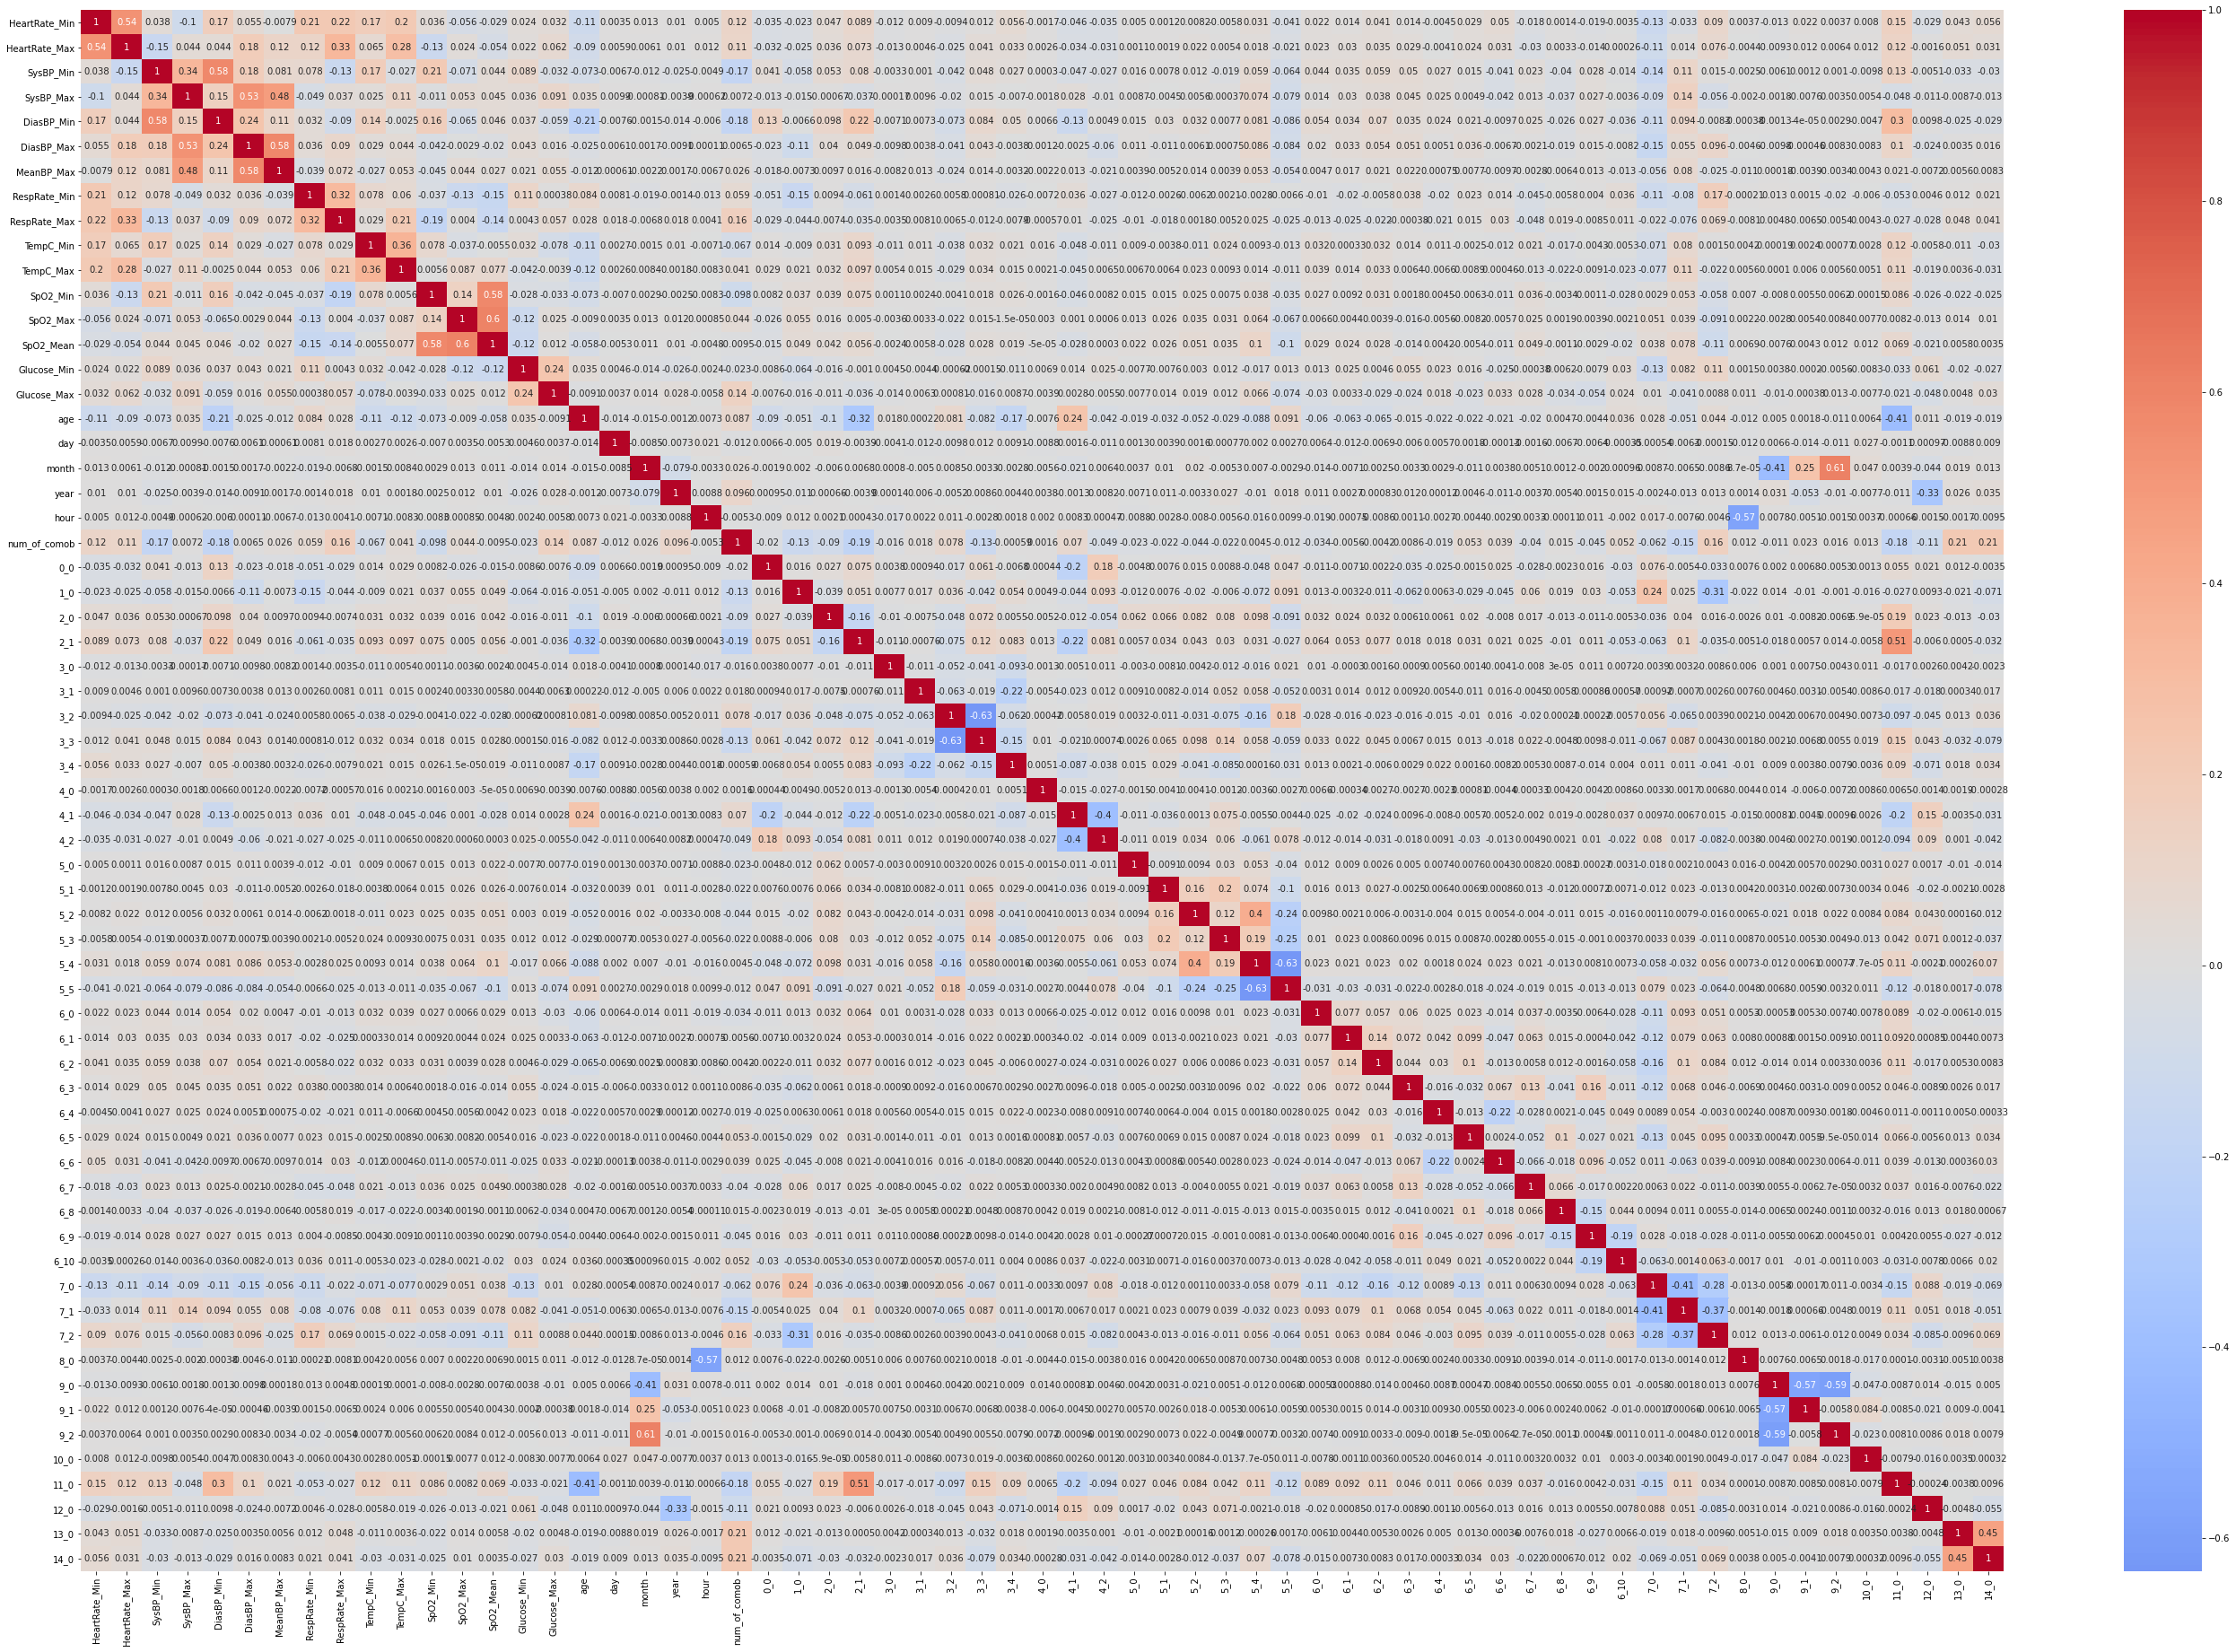

In [ ]:
# Correlation heatmap after removing highly correlated features
heatmap_low_corr = X_train_clean.corr()
plt.figure(figsize=(48,32))  
ax=sns.heatmap(heatmap_low_corr, annot=True, center=0, cmap='coolwarm', xticklabels=True, yticklabels=True)

# FEATURE ENGINEERING (not included but we show the done work)

This group of cells correspond to the part of the feature engineering which has not been run for this project. Here, we explain the reason why we do not include it and we show the done work. We have not commented out the results, since they have been defined in a way that can be run but not affect the rest of the project, so that we can see what we obtained.

## Principal Component Analysis

Also, we define a Principal Component Analysis (_PCA_) in order to reduce the dimensionality of the numerical features, so that the new reduced space of dimensions still explains a certain portion of the original variability of the data. First, noting that this step comes after the preprocessing, it would take into account all features (not just numerical), since the categoricals will already be encoded. Then, in order to choose the percentage of the original data dimensionality to keep (that is, the _n-components_ parameter of the _PCA_ function, we will set it as _'mle'_, therefore making the algorithm compute Minka's MLE in order to guess the dimension. Furthermore, by setting _whiten = True_, we ensure uncorrelated outputs with unit component-wise variances. Hence, by setting this parameter, we could not need to remove the features that are highly correlated between each other, since the new features computed by _PCA_ won't be correlated anymore.

We also show a feature selection method we tried during the project, computed with the _VarianceThreshold_ function, which we will finally not include in our final version, either.

In [ ]:
feat_sel = VarianceThreshold(threshold=0.2)

pca=PCA(n_components='mle',whiten=True)

## Define the pipeline with the preprocessor and the regressor
cleaning_pipeline_notadded = Pipeline(steps = [('preprocessor', preprocessor),#,
                                   #   ('feature_selection', feat_sel),
                                      ('pca', pca)])


In [ ]:
X_train_clean_notadded = cleaning_pipeline_notadded.fit_transform(X_train)
X_test_clean_notadded = cleaning_pipeline_notadded.transform(data_test)
print(X_train.shape)
print(X_train_clean_notadded.shape)

(20885, 45)
(20885, 75)


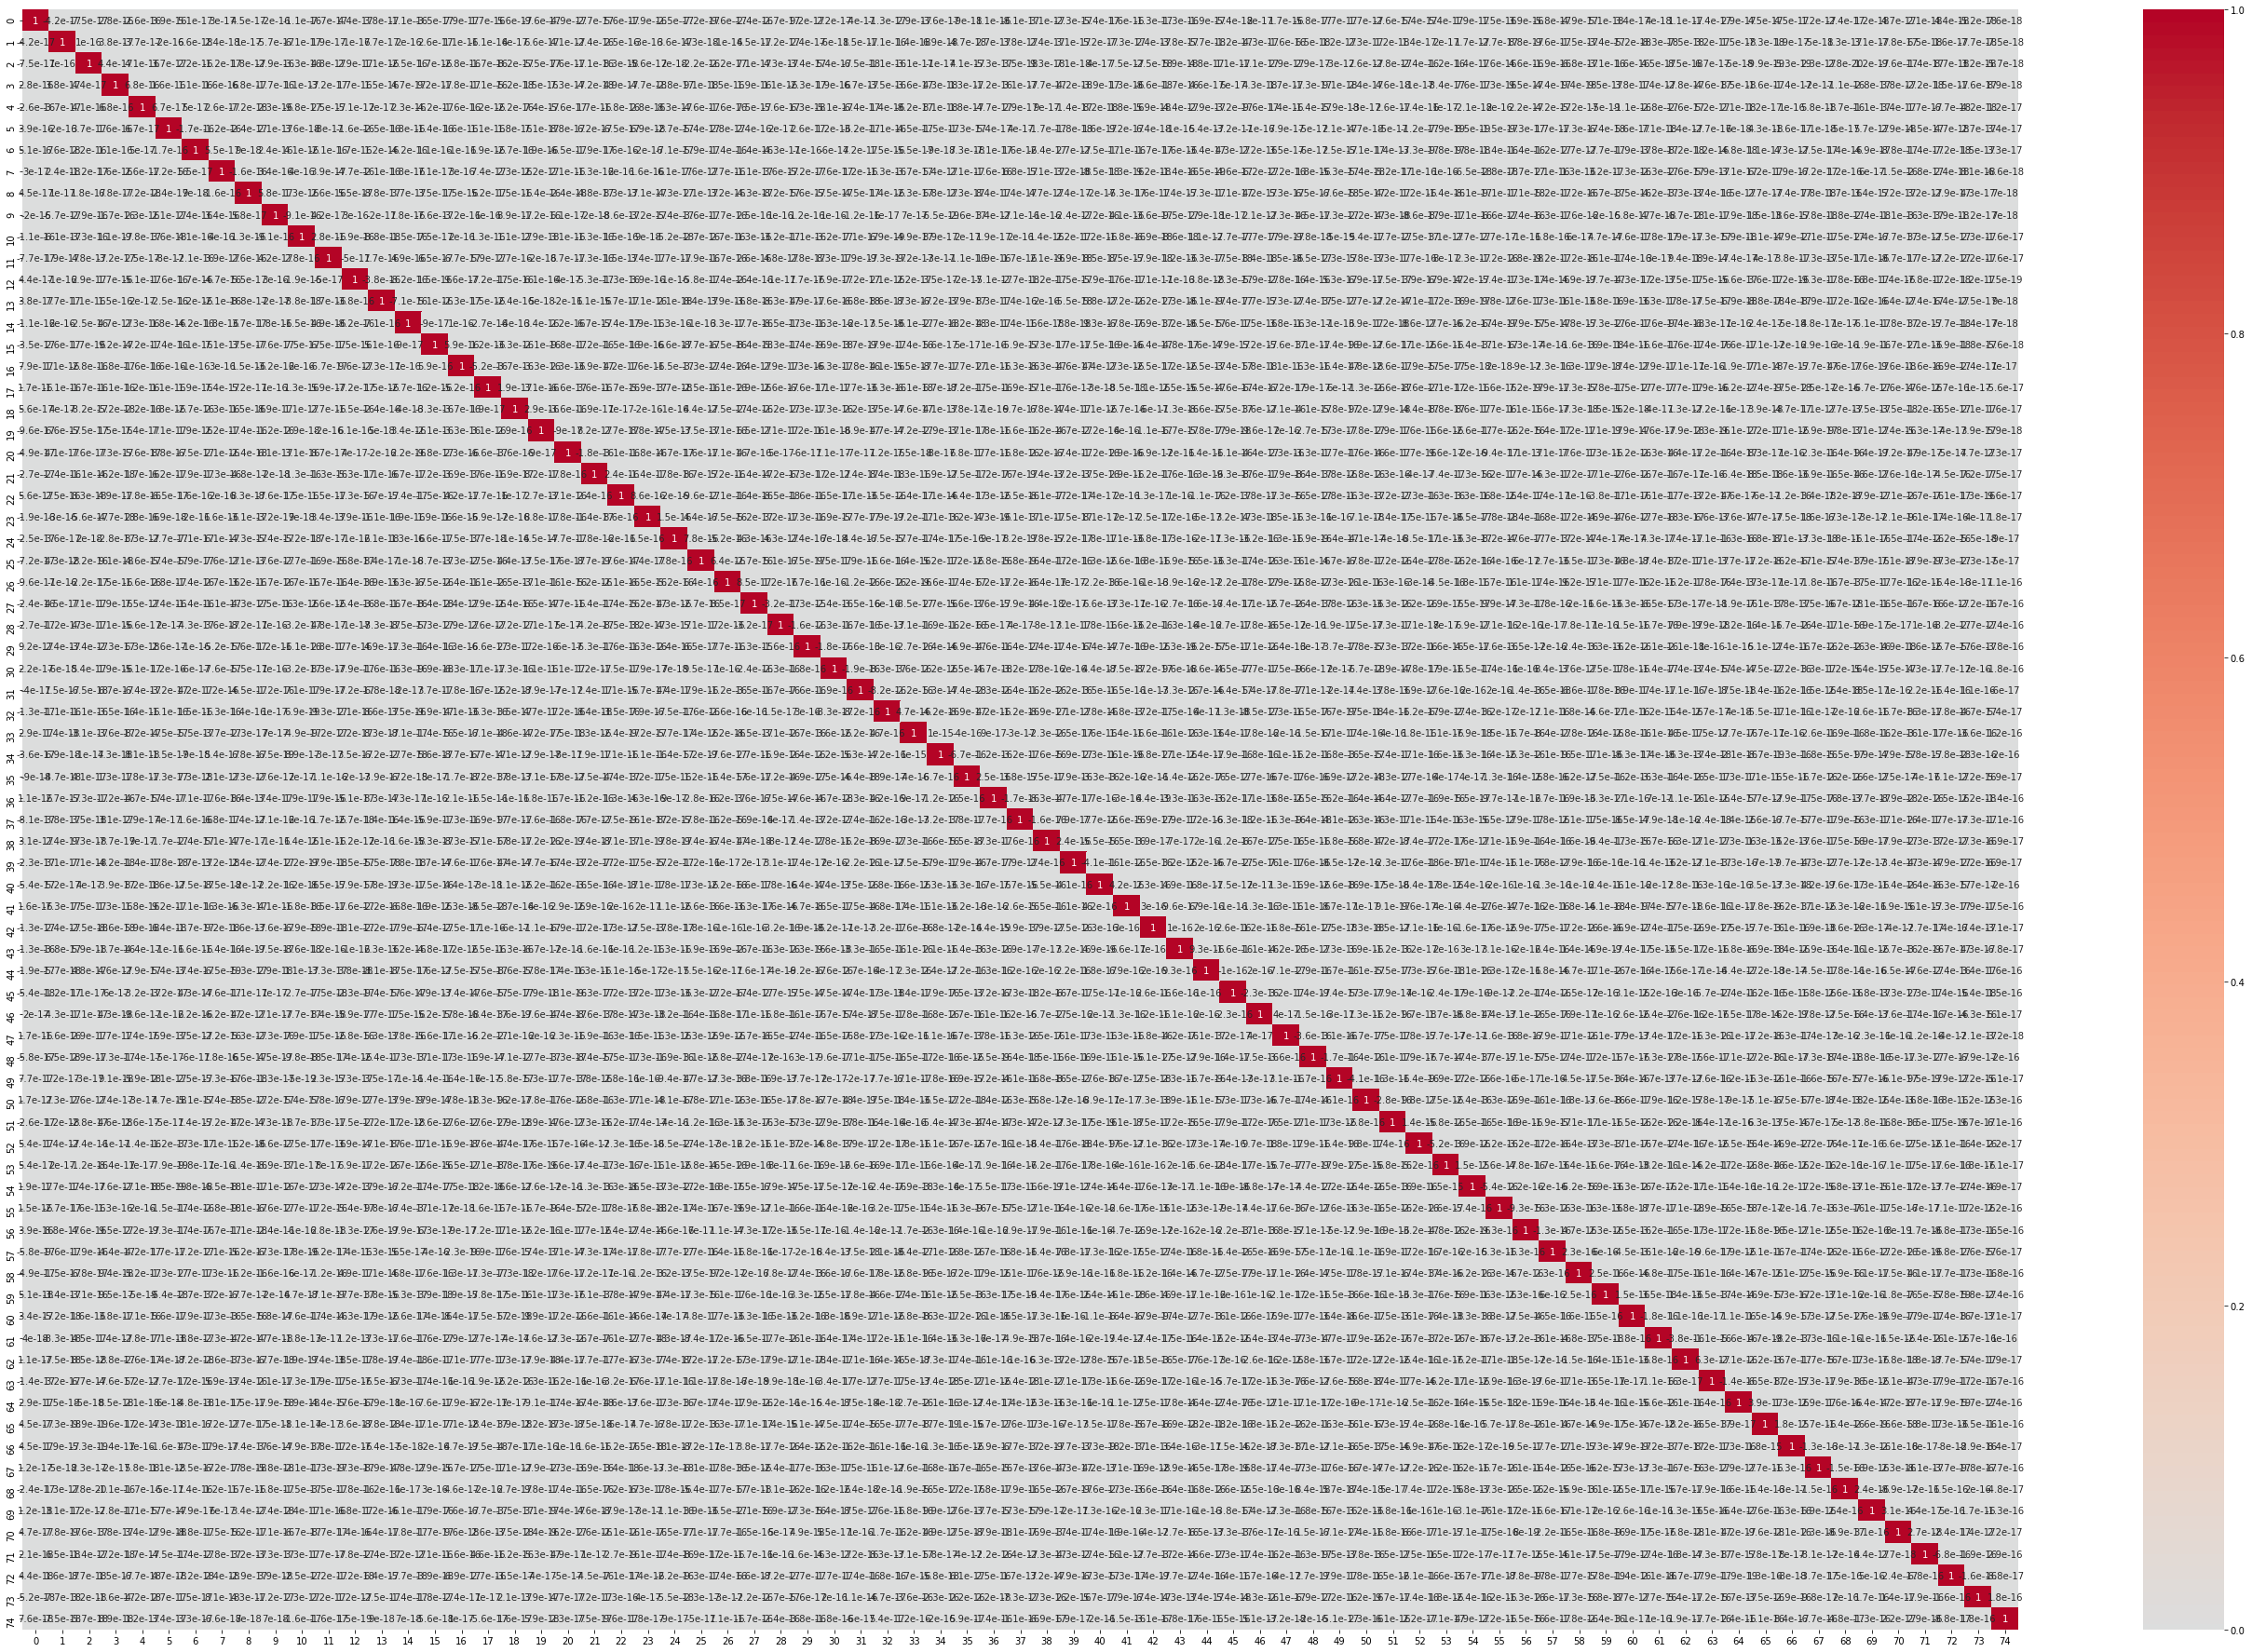

In [ ]:
X_train_clean_notadded = pd.DataFrame(X_train_clean_notadded)
X_test_clean_notadded = pd.DataFrame(X_test_clean_notadded)

# Correlation heatmap of all features
heatmap_corr_notadded = X_train_clean_notadded.corr()
plt.figure(figsize=(48,32))  
ax=sns.heatmap(heatmap_corr_notadded, annot=True, center=0, cmap='coolwarm', xticklabels=True, yticklabels=True)

Even though we end up with really uncorrelated features, we will finally not use PCA due to the following reasons:

- Firstly, because it ends up with more features than what we obtain by removing the highly correlated features (that is, more computational time).
- Then, due to not being able to know what exactly are the features and thus, if we wanted to later extract the feature importance from the tree-based models, we would get meaningless features. 
- Finally, because it also yielded worse results in our predictions.

# Decision Trees models

Here, we will implement five different tree-based models in order to predict the desired length of stay of patients by applying these regression models. We will GridSearch all of them in order to find the optimal parameters for each one of them. Thus, with the optimal version of each model (by setting the parameter values found in the gridsearch) we will later combine these optimal models to produce some ensemble models. 

However, the predictive models of an ensemble method tend to promote diversity among them in order to achieve better performance. Therefore, since we should avoid ensembling models that are quite correlated, we will not combine all the tested tree-based models.

Furthermore, we have not extracted the _feature importance_ attribute that tree-based models provide, because of the high computational time that has been required to run this project. Hence, if we extracted the important features and removed those that were not important by considering a given threshold, we would have had to re-run the GridSearchs of all models, to see if they had the same optimal parameters. Therefore, even though we are aware of its existence and that it may have slightly improved our predictions, we have decided not to include it in our project. 

Finally, as it can be seen in the upcoming sections for all tree-based models, we also tried a feature selection algorithm known as Recursive Feature Elimination (RFECV), which selected the number of features to use by cross-validation estimations. We included it inside a "regression pipeline" we created. However, each fit lasted almost 14x times more than without it and thus, we have not included in our final project, again due to the expensive computational time it would require. 

These two methods that we had to leave behind for our project would be two ways in which we could try to improve our results, if we had the computational power needed.

## XGBoost

### Defining the model

We begin by defining our Extreme Gradient Boosting (XGBoost) model with the XGBRegressor function.

Then, we briefly describe the model parameters that we are going to be set fixed:

- Booster: boosting method to use.
- Objective: the learning objective that will be used.
- Evaluation metric: the metric that will be used for data evaluation.
- Max depth: maximum depth of a tree. Cannot be very large (overfiting) nor very low (missing information).
- Tree method: the tree construction algorithm that will be used.


In [ ]:
## Define the first regressor 
xgb_reg=xgb.XGBRegressor(booster='gbtree',objective='reg:squarederror', eval_metric='rmse', 
                         max_depth=9, tree_method='hist')


## Define the pipeline with the Recursive Feature Elimination
## and the regressor, which we did not finally use due to the 
## high computational time it took (14x times longer)
feat_sel = RFECV(estimator=SGDRegressor())
pipeline_xgb = Pipeline(steps = [('feature_selection', feat_sel),
                                 ('regressor', xgb_reg)])

Now, we define the grid of values that we will use for the GridSearch:

- Number of estimators: the number of boosting stages to perform. Here, we have reduced the number of different values, since we originally also tried 25 and 50. This is due to having tried several times and never had them as the optimal solution, therefore removing them due to lower computational time it takes.
- Eta: commonly known as _learning rate_, it is a step size shrinkage used to prevent overfitting.
- Subsample: subsample ratio of the training instances to prevent overfitting.

Furthermore, we will work with the _neg root mean squared error_ score for the GridSearch, since the evaluation metric we were asked to use was _root mean squared error_ (RMSE).

In [ ]:
parameters_xgb = {'n_estimators': [100,200,300],
                  'eta': [0.05,0.1,0.2,0.3],
                  'subsample':[0.5,0.75,1]}
              

### Fitting the model and checking performance

Now, we define the _GridSearch_ we will run to get the optimal values for each parameter and fit it with our training data. Then, we print the best parameters that it finds.

In [ ]:
grid_xgb = GridSearchCV(xgb_reg, param_grid = parameters_xgb, scoring='neg_root_mean_squared_error', cv=5, verbose=3)
grid_xgb.fit(X_train_clean,y_train_clean)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ......eta=0.05, n_estimators=100, subsample=0.5; total time=   1.6s
[CV 2/5] END ......eta=0.05, n_estimators=100, subsample=0.5; total time=   1.7s
[CV 3/5] END ......eta=0.05, n_estimators=100, subsample=0.5; total time=   1.9s
[CV 4/5] END ......eta=0.05, n_estimators=100, subsample=0.5; total time=   1.6s
[CV 5/5] END ......eta=0.05, n_estimators=100, subsample=0.5; total time=   1.6s
[CV 1/5] END .....eta=0.05, n_estimators=100, subsample=0.75; total time=   1.8s
[CV 2/5] END .....eta=0.05, n_estimators=100, subsample=0.75; total time=   2.1s
[CV 3/5] END .....eta=0.05, n_estimators=100, subsample=0.75; total time=   1.7s
[CV 4/5] END .....eta=0.05, n_estimators=100, subsample=0.75; total time=   1.6s
[CV 5/5] END .....eta=0.05, n_estimators=100, subsample=0.75; total time=   1.6s
[CV 1/5] END ........eta=0.05, n_estimators=100, subsample=1; total time=   1.9s
[CV 2/5] END ........eta=0.05, n_estimators=100

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, eval_metric='rmse',
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=9, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
          

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid_xgb.best_score_)
print("Best parameters")
grid_xgb.best_params_ 

Best parameter (CV score=-4.707):
Best parameters


{'eta': 0.05, 'n_estimators': 100, 'subsample': 0.75}

Here, we define an optimal version of this model, which will be later used for the ensemble methods.

In [ ]:
xgb_reg_opt=xgb.XGBRegressor(booster='gbtree',objective='reg:squarederror', eval_metric='rmse', 
                         max_depth=9, tree_method='hist')
xgb_reg_opt.set_params(**grid_xgb.best_params_ )

XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, eta=0.05,
             eval_metric='rmse', gamma=None, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=9,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.75, tree_method='hist',
             validate_parameters=None, verbosity=None)

Now, we assess the model's performance by predicting with the training X.

In [ ]:
## Predictions from the training set
insample_y_pred_xgb = grid_xgb.predict(X_train_clean)

## RMSE of those predictions
print('Insample RMSE : ' + str(np.sqrt(mean_squared_error(y_train_clean,insample_y_pred_xgb))))

Insample RMSE : 2.5385435050126595


### Assessing predictions with the model

We get our predictions for the cleaned X_test.

In [ ]:
## Get the predictions of the test set
y_pred_xgb=grid_xgb.predict(X_test_clean) 

print(y_pred_xgb.mean())

3.763111


Now, we just create the file with the _icustay id_ and the predicted probabilities of death.

In [ ]:
test_kaggle_xgb = pd.DataFrame(data_test.index) ## The unique ID
test_kaggle_xgb["LOS"]=y_pred_xgb

In [ ]:
test_kaggle_xgb.to_csv("xgb_29-11.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 4.30961

## CatBoost

### Defining the model

We begin by defining our Categorical Boosting (CatBoost) model with the CatBoostRegressor function.

Then, we briefly describe the model parameters that we are going to be set fixed:

- Loss function: metric to use in the training of the model.
- Boosting from average: whether to initialize, or not, with the best, approximated constant value for the specified loss function.
- Boosting type: boosting method that will be used.
- Evaluation metric: the metric to use for overfitting detection and best model selection.
- Depth: maximum depth of a tree. Cannot be very large (overfiting) nor very low (missing information).
- Bootstrap type: defines the method for sampling the weights of objects.
- Random subspace method: percentage of features to use at each split selection, when features are selected over again at random.


In [ ]:
cat_reg=CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE', boost_from_average=True, 
                          boosting_type='Plain', rsm=0.75, depth=9, bootstrap_type='Bayesian')

## Define the pipeline with the Recursive Feature Elimination
## and the regressor, which we did not finally use due to the 
## high computational time it took (14x times longer)
feat_sel = RFECV(estimator=SGDRegressor())
pipeline_cat = Pipeline(steps = [('feature_selection', feat_sel),
                             ('regressor', cat_reg)])

Now, we define the grid of values that we will use for the GridSearch:

- Number of iterations: the maximum number of trees that can be built.  
- Scoring function: the score type used to select the next split during the tree construction. The selected are the ones that are supported when using a CPU instead of a GPU.   
- Growing policy: defines how to perform greedy tree construction.      

Furthermore, we will work with the _neg root mean squared error_ score for the GridSearch, since the evaluation metric we were asked to use was _root mean squared error_ (RMSE).

In [ ]:
parameters_cat = { 'iterations': [100,250,500,1000],
              'score_function':['Cosine','L2'],
              'grow_policy':['SymmetricTree','Depthwise']
              }

### Fitting the model and checking performance

Now, we define the _GridSearch_ we will run to get the optimal values for each parameter and fit it with our training data. Then, we print the best parameters that it finds.

In [ ]:
grid_cat = GridSearchCV(cat_reg, param_grid = parameters_cat, scoring='neg_root_mean_squared_error', cv=5, verbose=3)
grid_cat.fit(X_train_clean,y_train_clean)

Se han truncado las últimas 5000 líneas del flujo de salida.
8:	learn: 4.4963348	total: 328ms	remaining: 36.1s
9:	learn: 4.4465148	total: 358ms	remaining: 35.4s
10:	learn: 4.4052777	total: 384ms	remaining: 34.6s
11:	learn: 4.3577181	total: 421ms	remaining: 34.7s
12:	learn: 4.3228670	total: 456ms	remaining: 34.6s
13:	learn: 4.2717738	total: 489ms	remaining: 34.4s
14:	learn: 4.2413440	total: 520ms	remaining: 34.1s
15:	learn: 4.2012170	total: 552ms	remaining: 34s
16:	learn: 4.1600838	total: 583ms	remaining: 33.7s
17:	learn: 4.1246201	total: 617ms	remaining: 33.7s
18:	learn: 4.0918652	total: 649ms	remaining: 33.5s
19:	learn: 4.0530583	total: 682ms	remaining: 33.4s
20:	learn: 4.0211269	total: 712ms	remaining: 33.2s
21:	learn: 3.9910312	total: 744ms	remaining: 33.1s
22:	learn: 3.9616328	total: 777ms	remaining: 33s
23:	learn: 3.9321273	total: 822ms	remaining: 33.4s
24:	learn: 3.9123380	total: 847ms	remaining: 33s
25:	learn: 3.8827294	total: 887ms	remaining: 33.2s
26:	learn: 3.8574909	total: 9

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fddcb7eb220>,
             param_grid={'grow_policy': ['SymmetricTree', 'Depthwise'],
                         'iterations': [100, 250, 500, 1000],
                         'score_function': ['Cosine', 'L2']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid_cat.best_score_)
grid_cat.best_params_ 

Best parameter (CV score=-4.647):


{'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'score_function': 'Cosine'}

Here, we define an optimal version of this model, which will be later used for the ensemble methods.

In [ ]:
cat_reg_opt=CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE', boost_from_average=True, 
                          boosting_type='Plain', rsm=0.75, depth=9, bootstrap_type='Bayesian')
cat_reg_opt.set_params(**grid_cat.best_params_)

Now, we assess the model's performance by predicting with the training X.

In [ ]:
## Predictions from the training set
insample_y_pred_cat = grid_cat.predict(X_train_clean)

## RMSE of those predictions
print('Insample RMSE : ' + str(np.sqrt(mean_squared_error(y_train_clean,insample_y_pred_cat))))

Insample RMSE : 2.146570586792304


### Assessing predictions with the model

We get our predictions for the cleaned X_test.

In [ ]:
## Get the predictions of the test set
y_pred_cat=grid_cat.predict(X_test_clean) 

print(y_pred_cat.mean())

3.7412250423434408


Now, we just create the file with the _icustay id_ and the predicted probabilities of death.

In [ ]:
test_kaggle_cat = pd.DataFrame(data_test.index) ## The unique ID
test_kaggle_cat["LOS"]=y_pred_cat

In [ ]:
test_kaggle_cat.to_csv("cat_03-12.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 4.28583

## GradientBoosting

### Defining the model

We begin by defining our Gradient Boosting model with the GradientBoostingRegressor function.

Then, we briefly describe the model parameters that we are going to be set fixed:

- Criterion: the function to measure the quality of a split. The chosen _friedman mse_ is an improvement of the original _mse_ function.
- Warm start: whether to reuse the solution of the previous call to fit and add more estimators to the ensemble.
- Max depth: maximum depth of the individual regression estimators, which limits the number of nodes in the tree.   
- Max features: the number of features to consider when looking for the best split.   


In [ ]:
grad_reg=GradientBoostingRegressor(criterion='friedman_mse',warm_start=True, max_depth=9, max_features='sqrt')

## Define the pipeline with the Recursive Feature Elimination
## and the regressor, which we did not finally use due to the 
## high computational time it took (14x times longer)
feat_sel = RFECV(estimator=SGDRegressor())
pipeline_grad = Pipeline(steps = [('feature_selection', feat_sel),
                             ('regressor', grad_reg)])

Now, we define the grid of values that we will use for the GridSearch:

- Number of estimators: the number of boosting stages to perform. Here, we have reduced the number of different values, since we originally also tried 25 and 50. This is due to having tried several times and never had them as the optimal solution, therefore removing them due to lower computational time it takes. Furthermore gradient boosting is fairly robust to over-fitting, so a large number usually results in better performance.
- Min samples leaf: the minimum number of samples required to be at a leaf node.   
- Min samples split: the minimum number of samples required to split an internal node.   
- Subsample: the fraction of samples to be used for fitting the individual base learners.   
- Learning rate: step size shrinkage used to prevent overfitting.       

Furthermore, we will work with the _neg root mean squared error_ score for the GridSearch, since the evaluation metric we were asked to use was _root mean squared error_ (RMSE).

In [ ]:
parameters_grad = { 'n_estimators': [100,200], 
              'min_samples_leaf':[5,15],
              'min_samples_split':[10,30],
              'subsample':[0.5,0.75,1],
              'learning_rate':[0.05,0.1,0.2]}
            

### Fitting the model and checking performance

Now, we define the _GridSearch_ we will run to get the optimal values for each parameter and fit it with our training data. Then, we print the best parameters that it finds.

In [ ]:
grid_grad = GridSearchCV(grad_reg, param_grid = parameters_grad, scoring='neg_root_mean_squared_error', cv=5, verbose=3)
grid_grad.fit(X_train_clean,y_train_clean)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END learning_rate=0.05, min_samples_leaf=5, min_samples_split=10, n_estimators=100, subsample=0.5; total time=   1.2s
[CV 2/5] END learning_rate=0.05, min_samples_leaf=5, min_samples_split=10, n_estimators=100, subsample=0.5; total time=   1.1s
[CV 3/5] END learning_rate=0.05, min_samples_leaf=5, min_samples_split=10, n_estimators=100, subsample=0.5; total time=   1.2s
[CV 4/5] END learning_rate=0.05, min_samples_leaf=5, min_samples_split=10, n_estimators=100, subsample=0.5; total time=   1.2s
[CV 5/5] END learning_rate=0.05, min_samples_leaf=5, min_samples_split=10, n_estimators=100, subsample=0.5; total time=   1.2s
[CV 1/5] END learning_rate=0.05, min_samples_leaf=5, min_samples_split=10, n_estimators=100, subsample=0.75; total time=   1.6s
[CV 2/5] END learning_rate=0.05, min_samples_leaf=5, min_samples_split=10, n_estimators=100, subsample=0.75; total time=   1.6s
[CV 3/5] END learning_rate=0.05, min_samples_le

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(max_depth=9,
                                                 max_features='sqrt',
                                                 warm_start=True),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'min_samples_leaf': [5, 15],
                         'min_samples_split': [10, 30],
                         'n_estimators': [100, 200],
                         'subsample': [0.5, 0.75, 1]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid_grad.best_score_)
grid_grad.best_params_ 

Best parameter (CV score=-4.635):


{'learning_rate': 0.05,
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 100,
 'subsample': 0.75}

Here, we define an optimal version of this model, which will be later used for the ensemble methods.

In [ ]:
grad_reg_opt=GradientBoostingRegressor(criterion='friedman_mse',warm_start=True)
grad_reg_opt.set_params(**grid_grad.best_params_ )

GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=15,
                          min_samples_split=10, subsample=0.75,
                          warm_start=True)

Now, we assess the model's performance by predicting with the training X.

In [ ]:
## Predictions from the training set
insample_y_pred_grad = grid_grad.predict(X_train_clean)

## RMSE of those predictions
print('Insample RMSE : ' + str(np.sqrt(mean_squared_error(y_train_clean,insample_y_pred_grad))))

Insample RMSE : 3.766277175810042


### Assessing predictions with the model

We get our predictions for the cleaned X_test.

In [ ]:
## Get the predictions of the test set
y_pred_grad=grid_grad.predict(X_test_clean) 

print(y_pred_grad.mean())

3.7001867580890235


Now, we just create the file with the _icustay id_ and the predicted probabilities of death.

In [ ]:
test_kaggle_grad = pd.DataFrame(data_test.index) ## The unique ID
test_kaggle_grad["LOS"]=y_pred_grad

In [ ]:
test_kaggle_grad.to_csv("grad_more_03_12.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 4.23845

## RandomForest

### Defining the model

We begin by defining our Random Forest model with the RandomForestRegressor function.

Then, we briefly describe the model parameters that we are going to be set fixed:

- Criterion: the function to measure the quality of a split. The chosen _friedman mse_ is an improvement of the original _mse_ function.
- Warm start: whether to reuse the solution of the previous call to fit and add more estimators to the ensemble.
- Max depth: maximum depth of the individual regression estimators, which limits the number of nodes in the tree.   
- Max features: the number of features to consider when looking for the best split.   
- Bootstrap: whether bootstrap samples are used when building trees.   
- Oob score: whether to use out-of-bag samples to estimate the generalization score when bootstrapping is enabled. 
- Max samples: the number of samples to draw from the training set in order to train each base estimator.


In [ ]:
for_reg=RandomForestRegressor(criterion='friedman_mse',warm_start=True, max_depth=9, 
                              max_features='sqrt', bootstrap=True, oob_score=True, max_samples=0.45)

## Define the pipeline with the Recursive Feature Elimination
## and the regressor, which we did not finally use due to the 
## high computational time it took (14x times longer)
feat_sel = RFECV(estimator=SGDRegressor())
pipeline_for = Pipeline(steps = [('feature_selection', feat_sel),
                             ('regressor', for_reg)])

Now, we define the grid of values that we will use for the GridSearch:

- Number of estimators: the number of trees in the forest. Here, we have not reduced the number of different values, since there are not that many more parameters that we add to the GridSearch and hence, we can try more of them and still not have a huge computational time. 
- Min samples leaf: the minimum number of samples required to be at a leaf node.   
- Min samples split: the minimum number of samples required to split an internal node. 

Furthermore, we will work with the _neg root mean squared error_ score for the GridSearch, since the evaluation metric we were asked to use was _root mean squared error_ (RMSE).

In [ ]:
parameters_for = { 'n_estimators': [25,50,100,200,300], 
              'min_samples_leaf':[5,15],
              'min_samples_split':[10,30]}

### Fitting the model and checking performance

Now, we define the _GridSearch_ we will run to get the optimal values for each parameter and fit it with our training data. Then, we print the best parameters that it finds.

In [ ]:
grid_for = GridSearchCV(for_reg, param_grid = parameters_for, scoring='neg_root_mean_squared_error', cv=5, verbose=3)
grid_for.fit(X_train_clean,y_train_clean)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.3s
[CV 2/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.2s
[CV 3/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.2s
[CV 4/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.2s
[CV 5/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.2s
[CV 1/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV 2/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV 3/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV 4/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV 5/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV 1/5] END min_samples_lea

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(criterion='friedman_mse',
                                             max_depth=9, max_features='sqrt',
                                             max_samples=0.45, oob_score=True,
                                             warm_start=True),
             param_grid={'min_samples_leaf': [5, 15],
                         'min_samples_split': [10, 30],
                         'n_estimators': [25, 50, 100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid_for.best_score_)
grid_for.best_params_ 

Best parameter (CV score=-4.759):


{'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 300}

Here, we define an optimal version of this model, which will be later used for the ensemble methods.

In [ ]:
for_reg_opt=RandomForestRegressor(criterion='friedman_mse',warm_start=True, max_depth=9, 
                              max_features='sqrt', bootstrap=True, oob_score=True, max_samples=0.45)
for_reg_opt.set_params(**grid_for.best_params_ )

RandomForestRegressor(criterion='friedman_mse', max_depth=9,
                      max_features='sqrt', max_samples=0.45, min_samples_leaf=5,
                      min_samples_split=10, n_estimators=300, oob_score=True,
                      warm_start=True)

Now, we assess the model's performance by predicting with the training X.

In [ ]:
## Predictions from the training set
insample_y_pred_for = grid_for.predict(X_train_clean)

## RMSE of those predictions
print('Insample RMSE : ' + str(np.sqrt(mean_squared_error(y_train_clean,insample_y_pred_for))))

Insample RMSE : 4.441424348379181


### Assessing predictions with the model

We get our predictions for the cleaned X_test.

In [ ]:
## Get the predictions of the test set
y_pred_for=grid_for.predict(X_test_clean) 

print(y_pred_for.mean())

3.7041711415563308


Now, we just create the file with the _icustay id_ and the predicted probabilities of death.

In [ ]:
test_kaggle_for = pd.DataFrame(data_test.index) ## The unique ID
test_kaggle_for["LOS"]=y_pred_for

In [ ]:
test_kaggle_for.to_csv("for_03-12.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 4.37015

## ExtraTrees

### Defining the model

We begin by defining our Extra Trees model with the ExtraTreesRegressor function.

Then, we briefly describe the model parameters that we are going to be set fixed:

- Warm start: whether to reuse the solution of the previous call to fit and add more estimators to the ensemble.
- Max depth: maximum depth of the individual regression estimators, which limits the number of nodes in the tree.   
- Max features: the number of features to consider when looking for the best split.   
- Bootstrap: whether bootstrap samples are used when building trees.   
- Oob score: whether to use out-of-bag samples to estimate the generalization score when bootstrapping is enabled. 
- Max samples: the number of samples to draw from the training set in order to train each base estimator.


In [ ]:
extra_reg = ExtraTreesRegressor(max_depth=9,max_features='sqrt',bootstrap=True,oob_score=True,
                                warm_start=True,max_samples=0.45)

## Define the pipeline with the Recursive Feature Elimination
## and the regressor, which we did not finally use due to the 
## high computational time it took (14x times longer)
feat_sel = RFECV(estimator=SGDRegressor())
pipeline_for = Pipeline(steps = [('feature_selection', feat_sel),
                             ('regressor', extra_reg)])

Now, we define the grid of values that we will use for the GridSearch:

- Number of estimators: the number of trees in the forest. Here, we have not reduced the number of different values, since there are not that many more parameters that we add to the GridSearch and hence, we can try more of them and still not have a huge computational time. 
- Min samples leaf: the minimum number of samples required to be at a leaf node.   
- Min samples split: the minimum number of samples required to split an internal node. 

Furthermore, we will work with the _neg root mean squared error_ score for the GridSearch, since the evaluation metric we were asked to use was _root mean squared error_ (RMSE).

In [ ]:
parameters_extra = { 'n_estimators': [25,50,100,200,300], 
              'min_samples_leaf':[5,15],
              'min_samples_split':[10,30]}

### Fitting the model and checking performance

Now, we define the _GridSearch_ we will run to get the optimal values for each parameter and fit it with our training data. Then, we print the best parameters that it finds.

In [ ]:
grid_extra = GridSearchCV(extra_reg, param_grid = parameters_extra, scoring='neg_root_mean_squared_error', cv=5, verbose=3)
grid_extra.fit(X_train_clean,y_train_clean)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.1s
[CV 2/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.1s
[CV 3/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.1s
[CV 4/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.1s
[CV 5/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=25; total time=   0.1s
[CV 1/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.2s
[CV 2/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV 3/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV 4/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV 5/5] END min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.3s
[CV 1/5] END min_samples_lea

GridSearchCV(cv=5,
             estimator=ExtraTreesRegressor(bootstrap=True, max_depth=9,
                                           max_features='sqrt',
                                           max_samples=0.45, oob_score=True,
                                           warm_start=True),
             param_grid={'min_samples_leaf': [5, 15],
                         'min_samples_split': [10, 30],
                         'n_estimators': [25, 50, 100, 200, 300]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
print("Best parameter (CV score=%0.3f):" % grid_extra.best_score_)
grid_extra.best_params_ 

Best parameter (CV score=-4.887):


{'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}

Here, we define an optimal version of this model, which will be later used for the ensemble methods.

In [ ]:
extra_reg_opt=ExtraTreesRegressor(max_depth=9,max_features='sqrt',bootstrap=True,oob_score=True,
                                warm_start=True,max_samples=0.45)
extra_reg_opt.set_params(**grid_extra.best_params_ )

ExtraTreesRegressor(bootstrap=True, max_depth=9, max_features='sqrt',
                    max_samples=0.45, min_samples_leaf=5, min_samples_split=10,
                    oob_score=True, warm_start=True)

Now, we assess the model's performance by predicting with the training X.

In [ ]:
## Predictions from the training set
insample_y_pred_extra = grid_extra.predict(X_train_clean)

## RMSE of those predictions
print('Insample RMSE : ' + str(np.sqrt(mean_squared_error(y_train_clean,insample_y_pred_extra))))

Insample RMSE : 4.776143707443396


### Assessing predictions with the model

We get our predictions for the cleaned X_test.

In [ ]:
## Get the predictions of the test set
y_pred_extra=grid_extra.predict(X_test_clean) 

print(y_pred_extra.mean())

3.679414144708593


Now, we just create the file with the _icustay id_ and the predicted probabilities of death.

In [ ]:
test_kaggle_extra = pd.DataFrame(data_test.index) ## The unique ID
test_kaggle_extra["LOS"]=y_pred_extra

In [ ]:
test_kaggle_extra.to_csv("extra_05-12.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 4.51230

# Ensembles

Finally, we will implement the four different ensembles classes that are provided in the _Mlens_ Python package, which perfectly work with all the _Sklearn_ models. Since we have already computed a GridSearch over the models, we will not implement further GridSearchs for these ensemble models. 

The models that will not be added to our ensembles are the RandomForest and the ExtraTrees, since they are the ones that provided worst results and thus, since we will already be mixing highly correlated models (due to all of them being tree-based models), we do not use them. Furthermore, we will add the Support Vector Machine (SVM) regressor into the first, in order to add one model that is not tree-based and try to improve our ensembles. 

Then, the CatBoost and XGBoost will be each in one of the two layers that we will define and finally, the meta learner will be the GradientBoosting model, since it was the one that provided the best results.


## SuperLearner

The Super Learner (Stacking Ensemble) is a supervised ensemble algorithm that maps training sets into a prediction sets by K-fold estimations. However, Stacking K-fold predictions to cover an entire training set is computationally expensive. Thus, with large data, ensembles that fit on subsets of the data can achieve similar performance at a fraction of the computational time. If data was noisy or with high-variance, the Stacking Ensemble would perform better than the faster ensemble methods. However, since our data has been cleaned and scaled, this ensemble method may provide similar results in much more time. 

At the end of the project, we will compare the results.

First, we define the SuperLearner.

In [ ]:
sup_ens = SuperLearner(folds=5,scorer=mean_squared_error, verbose=2)
# Build the first layer

sup_ens.add([cat_reg_opt,
             SVR(C=0.1,kernel='linear',gamma=0.03)])

sup_ens.add([xgb_reg_opt])

sup_ens.add_meta(grad_reg_opt)
              

SuperLearner(array_check=None, backend=None, folds=5,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...b735820>)],
   n_jobs=-1, name='group-2', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=<function mean_squared_error at 0x7fddab735820>,
       shuffle=False, verbose=2)

We fit the SuperLearner with our cleaned X_train.

In [ ]:
sup_ens.fit(X_train_clean,y_train_clean)


Fitting 3 layers
Processing layer-1             Learning rate set to 0.063884
Learning rate set to 0.063884
Learning rate set to 0.063884
Learning rate set to 0.063884
Learning rate set to 0.063884
Learning rate set to 0.066176
0:	learn: 5.0733971	total: 61.6ms	remaining: 1m 1s
0:	learn: 5.1953630	total: 66.9ms	remaining: 1m 6s
0:	learn: 5.0377814	total: 81.5ms	remaining: 1m 21s
0:	learn: 5.1419092	total: 83.1ms	remaining: 1m 22s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Se han truncado las últimas 5000 líneas del flujo de salida.
144:	learn: 3.9013839	total: 14.4s	remaining: 1m 24s
147:	learn: 3.8470806	total: 14.5s	remaining: 1m 23s
149:	learn: 3.7958422	total: 14.5s	remaining: 1m 22s
149:	learn: 3.9047226	total: 14.5s	remaining: 1m 22s
145:	learn: 3.8766616	total: 14.4s	remaining: 1m 24s
148:	learn: 3.8432248	total: 14.5s	remaining: 1m 22s
150:	learn: 3.7934335	total: 14.6s	remaining: 1m 21s
141:	learn: 3.9428616	total: 14.6s	remaining: 1m 28s
146:	learn: 3.8734625	total: 14.5s	remaining: 1m 24s
150:	learn: 3.9014526	total: 14.6s	remaining: 1m 22s
145:	learn: 3.8970510	total: 14.5s	remaining: 1m 24s
149:	learn: 3.8408576	total: 14.6s	remaining: 1m 22s
151:	learn: 3.7845317	total: 14.6s	remaining: 1m 21s
147:	learn: 3.8710237	total: 14.6s	remaining: 1m 23s
142:	learn: 3.9398302	total: 14.6s	remaining: 1m 27s
150:	learn: 3.8349211	total: 14.6s	remaining: 1m 22s
146:	learn: 3.8921656	total: 14.6s	remaining: 1m 24s
151:	learn: 3.8937930	total: 14.7s	rem

SuperLearner(array_check=None, backend=None, folds=5,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...b735820>)],
   n_jobs=-1, name='group-2', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=<function mean_squared_error at 0x7fddab735820>,
       shuffle=False, verbose=2)

Now, we assess the model's performance by predicting with the training X.

In [ ]:
## Predictions from the training set
insample_y_pred_supens = sup_ens.predict(X_train_clean)

## RMSE of those predictions
print('Insample RMSE : ' + str(np.sqrt(mean_squared_error(y_train_clean,insample_y_pred_supens))))


Predicting 3 layers
Processing layer-1             done | 00:00:18
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:18
Insample RMSE : 4.292846438498147


We get our predictions for the cleaned X_test.

In [ ]:
y_pred_sup = sup_ens.predict(X_test_clean)
print(y_pred_sup.mean())


Predicting 3 layers
Processing layer-1             done | 00:00:04
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:04
3.712906


Now, we just create the file with the _icustay id_ and the predicted probabilities of death.

In [ ]:
test_kaggle_sup = pd.DataFrame(data_test.index) ## The unique ID
test_kaggle_sup["LOS"]=y_pred_sup

In [ ]:
test_kaggle_sup.to_csv("sup_ens_04-12_final.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 4.39713

## BlendEnsemble

The Blend Ensemble is a supervised ensemble closely related to the SuperLearner. It differs in the following: in order to estimate the predictions that the meta-learner will use, the BlendEnsemble will provide a subset of the data to predict its complementary data and thus, the meta learner will be fitted on those predictions. 

By only fitting every weak-learner once on a subset of the full training data, this ensemble class is appropiate for handling very large datasets, since it can achieve similar performance to more sophisticated ensembles much more quickly. The price to pay of this approach is the lost information at each stage, as one layer will not see the training data used by the previous layer. However, since our data has been cleaned and scaled, the aforementioned price to pay should not be a problem.

First, we define the BlendEnsemble.

In [ ]:
ble_ens = BlendEnsemble(scorer=mean_squared_error, verbose=2) 

ble_ens.add([cat_reg_opt,
             SVR(C=0.1,kernel='linear',gamma=0.03)])

ble_ens.add([xgb_reg_opt])

ble_ens.add_meta(grad_reg_opt)

BlendEnsemble(array_check=None, backend=None,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=BlendIndex(X=None, raise_on_exception=...b735820>)],
   n_jobs=-1, name='group-5', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=<function mean_squared_error at 0x7fddab735820>,
       shuffle=False, test_size=0.5, verbose=2)

We fit the BlendEnsemble with our cleaned X_train.

In [ ]:
ble_ens.fit(X_train_clean,y_train_clean)


Fitting 3 layers
Processing layer-1             Learning rate set to 0.059312
Learning rate set to 0.066176
0:	learn: 5.1252345	total: 20.7ms	remaining: 20.7s
0:	learn: 5.1227661	total: 23.4ms	remaining: 23.4s
1:	learn: 5.0787280	total: 44.2ms	remaining: 22.1s
1:	learn: 5.0798639	total: 45.3ms	remaining: 22.6s
2:	learn: 5.0371753	total: 68.8ms	remaining: 22.9s
2:	learn: 5.0363827	total: 68.3ms	remaining: 22.7s
3:	learn: 4.9985500	total: 91.8ms	remaining: 22.9s
3:	learn: 4.9989333	total: 94.6ms	remaining: 23.5s
4:	learn: 4.9658354	total: 114ms	remaining: 22.8s
4:	learn: 4.9645049	total: 116ms	remaining: 23.1s
5:	learn: 4.9327854	total: 138ms	remaining: 22.8s
5:	learn: 4.9300055	total: 139ms	remaining: 23s
6:	learn: 4.8967136	total: 161ms	remaining: 22.9s
6:	learn: 4.8985739	total: 162ms	remaining: 23s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

7:	learn: 4.8721807	total: 181ms	remaining: 22.4s
7:	learn: 4.8731040	total: 187ms	remaining: 23.2s
8:	learn: 4.8460886	total: 205ms	remaining: 22.5s
8:	learn: 4.8474381	total: 213ms	remaining: 23.5s
9:	learn: 4.8221584	total: 227ms	remaining: 22.5s
9:	learn: 4.8215051	total: 240ms	remaining: 23.8s
10:	learn: 4.7985236	total: 251ms	remaining: 22.5s
10:	learn: 4.8006304	total: 271ms	remaining: 24.3s
11:	learn: 4.7774650	total: 280ms	remaining: 23.1s
11:	learn: 4.7796253	total: 299ms	remaining: 24.6s
12:	learn: 4.7490325	total: 302ms	remaining: 22.9s
13:	learn: 4.7274787	total: 322ms	remaining: 22.7s
12:	learn: 4.7578870	total: 324ms	remaining: 24.6s
14:	learn: 4.6996753	total: 345ms	remaining: 22.7s
13:	learn: 4.7414070	total: 347ms	remaining: 24.4s
15:	learn: 4.6772537	total: 367ms	remaining: 22.6s
14:	learn: 4.7227110	total: 372ms	remaining: 24.4s
16:	learn: 4.6597254	total: 389ms	remaining: 22.5s
15:	learn: 4.7051632	total: 399ms	remaining: 24.5s
17:	learn: 4.6383838	total: 410ms	rem

BlendEnsemble(array_check=None, backend=None,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=BlendIndex(X=None, raise_on_exception=...b735820>)],
   n_jobs=-1, name='group-5', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20,
       scorer=<function mean_squared_error at 0x7fddab735820>,
       shuffle=False, test_size=0.5, verbose=2)

Now, we assess the model's performance by predicting with the training X.

In [ ]:
## Predictions from the training set
insample_y_pred_bleens = ble_ens.predict(X_train_clean)

## RMSE of those predictions
print('Insample RMSE : ' + str(np.sqrt(mean_squared_error(y_train_clean,insample_y_pred_bleens))))


Predicting 3 layers
Processing layer-1             done | 00:00:18
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:18
Insample RMSE : 4.553891572037924


We get our predictions for the cleaned X_test.

In [ ]:
y_pred_ble = ble_ens.predict(X_test_clean)
print(y_pred_ble.mean())


Predicting 3 layers
Processing layer-1             done | 00:00:04
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:04
3.7758684


Now, we just create the file with the _icustay id_ and the predicted probabilities of death.

In [ ]:
test_kaggle_ble = pd.DataFrame(data_test.index) ## The unique ID
test_kaggle_ble["LOS"]=y_pred_ble

In [ ]:
test_kaggle_ble.to_csv("ble_ens_04-12_final.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 4.52543

## Subsemble

Subsemble is a supervised ensemble algorithm that uses subsets of the full data to fit a layer and then, each subset performs a K-folds estimation to map a training set into a prediction set. Each partition will reflect its test errors and thus, the algorithm will learn from each subset. After all predictions have been computed in the different layers, the meta learner will provide the final prediction by learning the best combination of subset-specific estimator predictions.

First, we define the Subsemble.

In [ ]:
sub_ens = Subsemble(folds=5,scorer=mean_squared_error, verbose=2)

sub_ens.add([cat_reg_opt,
             SVR(C=0.1,kernel='linear',gamma=0.03)])

sub_ens.add([xgb_reg_opt])

sub_ens.add_meta(grad_reg_opt)

Subsemble(array_check=None, backend=None, folds=5,
     layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=SubsetIndex(X=None, folds=5, partition...b735820>)],
   n_jobs=-1, name='group-8', raise_on_exception=True, transformers=[])],
   verbose=1)],
     model_selection=False, n_jobs=None, partition_estimator=None,
     partitions=2, raise_on_exception=True, random_state=None,
     sample_size=20,
     scorer=<function mean_squared_error at 0x7fddab735820>, shuffle=False,
     verbose=2)

We fit the Subsemble with our cleaned X_train.

In [ ]:
sub_ens.fit(X_train_clean,y_train_clean)


Fitting 3 layers
Processing layer-1             Learning rate set to 0.057257
Learning rate set to 0.057257
Learning rate set to 0.057257
Learning rate set to 0.059312
Learning rate set to 0.057256
Learning rate set to 0.057257
Learning rate set to 0.057257
Learning rate set to 0.059312
Learning rate set to 0.057257
Learning rate set to 0.057256
0:	learn: 4.9982301	total: 49ms	remaining: 49s
0:	learn: 5.2079654	total: 75.2ms	remaining: 1m 15s
0:	learn: 5.1928058	total: 70.2ms	remaining: 1m 10s
0:	learn: 5.2014735	total: 83.8ms	remaining: 1m 23s
0:	learn: 5.0836952	total: 71.8ms	remaining: 1m 11s
0:	learn: 5.1350863	total: 76.2ms	remaining: 1m 16s
0:	learn: 5.1277821	total: 76.1ms	remaining: 1m 16s
0:	learn: 5.1062865	total: 68.3ms	remaining: 1m 8s
1:	learn: 4.9571210	total: 128ms	remaining: 1m 3s
0:	learn: 5.1252345	total: 117ms	remaining: 1m 57s
1:	learn: 5.0933892	total: 129ms	remaining: 1m 4s
0:	learn: 5.1892903	total: 98.3ms	remaining: 1m 38s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Se han truncado las últimas 5000 líneas del flujo de salida.
488:	learn: 2.4701028	total: 39.3s	remaining: 41.1s
491:	learn: 2.2719693	total: 39.4s	remaining: 40.6s
480:	learn: 2.4916573	total: 39.3s	remaining: 42.4s
489:	learn: 2.2949934	total: 39.3s	remaining: 40.9s
491:	learn: 2.3849852	total: 39.2s	remaining: 40.5s
478:	learn: 2.6179954	total: 39.3s	remaining: 42.8s
544:	learn: 2.1624486	total: 39.1s	remaining: 32.6s
486:	learn: 2.3212721	total: 39.2s	remaining: 41.3s
507:	learn: 2.4350560	total: 39.3s	remaining: 38.1s
495:	learn: 2.3668117	total: 39.3s	remaining: 40s
489:	learn: 2.4670584	total: 39.4s	remaining: 41s
490:	learn: 2.2928647	total: 39.4s	remaining: 40.9s
492:	learn: 2.2700685	total: 39.4s	remaining: 40.6s
492:	learn: 2.3794331	total: 39.3s	remaining: 40.4s
545:	learn: 2.1614625	total: 39.1s	remaining: 32.5s
481:	learn: 2.4898821	total: 39.4s	remaining: 42.3s
479:	learn: 2.6161602	total: 39.4s	remaining: 42.7s
508:	learn: 2.4317812	total: 39.4s	remaining: 38s
491:	lear

Subsemble(array_check=None, backend=None, folds=5,
     layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=SubsetIndex(X=None, folds=5, partition...b735820>)],
   n_jobs=-1, name='group-8', raise_on_exception=True, transformers=[])],
   verbose=1)],
     model_selection=False, n_jobs=None, partition_estimator=None,
     partitions=2, raise_on_exception=True, random_state=None,
     sample_size=20,
     scorer=<function mean_squared_error at 0x7fddab735820>, shuffle=False,
     verbose=2)

Now, we assess the model's performance by predicting with the training X.

In [ ]:
## Predictions from the training set
insample_y_pred_subens = sub_ens.predict(X_train_clean)

## RMSE of those predictions
print('Insample RMSE : ' + str(np.sqrt(mean_squared_error(y_train_clean,insample_y_pred_subens))))


Predicting 3 layers
Processing layer-1             done | 00:00:09
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:09
Insample RMSE : 4.280000528025543


We get our predictions for the cleaned X_test.

In [ ]:
y_pred_sub = sub_ens.predict(X_test_clean)
print(y_pred_sub.mean())


Predicting 3 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:02
3.7133527


Now, we just create the file with the _icustay id_ and the predicted probabilities of death.

In [ ]:
test_kaggle_sub = pd.DataFrame(data_test.index) ## The unique ID
test_kaggle_sub["LOS"]=y_pred_sub

In [ ]:
test_kaggle_sub.to_csv("sub_ens_04-12_final.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 4.38398

## SequentialEnsemble

This last ensemble method allows the possibility of mixing the previously tested ensemble classes. In each layer of the Sequential Ensemble, the class of ensemble that will be used has to be specified.

First, we define the SequentialEnsemble.

In [ ]:
seq_ens = SequentialEnsemble(scorer=mean_squared_error, verbose=2)

seq_ens.add(cls='stack', estimators=[cat_reg_opt,
             SVR(C=0.1,kernel='linear',gamma=0.03)])

seq_ens.add(cls='subsemble', estimators=[xgb_reg_opt])

seq_ens.add_meta(grad_reg_opt)


SequentialEnsemble(array_check=None, backend=None,
          layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...735820>)],
   n_jobs=-1, name='group-12', raise_on_exception=True, transformers=[])],
   verbose=1)],
          model_selection=False, n_jobs=None, raise_on_exception=True,
          random_state=None, sample_size=20,
          scorer=<function mean_squared_error at 0x7fddab735820>,
          shuffle=False, verbose=2)

We fit the SequentialEnsemble with our cleaned X_train.

In [ ]:
seq_ens.fit(X_train_clean,y_train_clean)


Fitting 3 layers
Processing layer-1             Learning rate set to 0.059312
Learning rate set to 0.059312
Learning rate set to 0.066176
0:	learn: 5.1277821	total: 40ms	remaining: 40s
0:	learn: 5.1252345	total: 29.4ms	remaining: 29.4s
1:	learn: 5.0787280	total: 60.2ms	remaining: 30s
1:	learn: 5.0839901	total: 78.1ms	remaining: 38.9s
0:	learn: 5.1227661	total: 38.8ms	remaining: 38.8s
2:	learn: 5.0371753	total: 92.3ms	remaining: 30.7s
1:	learn: 5.0798639	total: 74.3ms	remaining: 37.1s
2:	learn: 5.0472913	total: 117ms	remaining: 39s
3:	learn: 4.9989333	total: 128ms	remaining: 32s
2:	learn: 5.0363827	total: 106ms	remaining: 35.1s
3:	learn: 5.0046345	total: 158ms	remaining: 39.3s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

3:	learn: 4.9985500	total: 145ms	remaining: 36.1s
4:	learn: 4.9718879	total: 190ms	remaining: 37.9s
4:	learn: 4.9658354	total: 163ms	remaining: 32.4s
5:	learn: 4.9366921	total: 222ms	remaining: 36.8s
4:	learn: 4.9645049	total: 177ms	remaining: 35.3s
5:	learn: 4.9327854	total: 205ms	remaining: 33.9s
6:	learn: 4.9028599	total: 250ms	remaining: 35.5s
5:	learn: 4.9300055	total: 215ms	remaining: 35.5s
6:	learn: 4.8985739	total: 235ms	remaining: 33.4s
7:	learn: 4.8768477	total: 277ms	remaining: 34.3s
7:	learn: 4.8721807	total: 266ms	remaining: 33s
6:	learn: 4.8967136	total: 250ms	remaining: 35.4s
8:	learn: 4.8545270	total: 308ms	remaining: 33.9s
8:	learn: 4.8460886	total: 301ms	remaining: 33.2s
7:	learn: 4.8731040	total: 284ms	remaining: 35.3s
9:	learn: 4.8292245	total: 355ms	remaining: 35.2s
9:	learn: 4.8221584	total: 329ms	remaining: 32.6s
8:	learn: 4.8474381	total: 323ms	remaining: 35.5s
10:	learn: 4.8068987	total: 385ms	remaining: 34.7s
10:	learn: 4.7985236	total: 361ms	remaining: 32.5s


SequentialEnsemble(array_check=None, backend=None,
          layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...735820>)],
   n_jobs=-1, name='group-12', raise_on_exception=True, transformers=[])],
   verbose=1)],
          model_selection=False, n_jobs=None, raise_on_exception=True,
          random_state=None, sample_size=20,
          scorer=<function mean_squared_error at 0x7fddab735820>,
          shuffle=False, verbose=2)

Now, we assess the model's performance by predicting with the training X.

In [ ]:
## Predictions from the training set
insample_y_pred_seqens = seq_ens.predict(X_train_clean)

## RMSE of those predictions
print('Insample RMSE : ' + str(np.sqrt(mean_squared_error(y_train_clean,insample_y_pred_seqens))))


Predicting 3 layers
Processing layer-1             done | 00:00:18
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:18
Insample RMSE : 4.414892885309908


We get our predictions for the cleaned X_test.

In [ ]:
y_pred_seq = seq_ens.predict(X_test_clean)
print(y_pred_seq.mean())


Predicting 3 layers
Processing layer-1             done | 00:00:04
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:04
3.7007496


Now, we just create the file with the _icustay id_ and the predicted probabilities of death.

In [ ]:
test_kaggle_seq = pd.DataFrame(data_test.index) ## The unique ID
test_kaggle_seq["LOS"]=y_pred_seq

In [ ]:
test_kaggle_seq.to_csv("seq_ens_04-12_final.csv", index = False)

After submitting the file to Kaggle, the score obtained with 50% of the test data is: 4.36552

# Final comparison between all models

Here, we show each of the models we have used throught this project, along with their corresponding Kaggle score. As we said, the weak learners of the ensemble methods should not be correlated in order to obtain a better performance. Therefore, even though we added the SVM regressor, the rest of the models we have been working with are tree-based models and thus, since they have been the weak learners of our ensemble methods, it makes sense that we have not obtained improved scores with these combination of models.

Here, we can see that the ensemble method with the worst score was the BlendEnsemble. Recalling what we previously introduced in the description of each ensemble, it seems that the loss of information that the BlendEnsemble had to pay in order to be computationally less expensive has finally been significant, providing the worst result of all.

The model that has reached the best score is ***GradientBoosting***, which has been highlighted in the table below.



| Model | Kaggle score |
| :-: | :-: |
| XGBoost | 4.30961 |
| CatBoost | 4.28583 |
| ***GradientBoosting*** | ***4.23845*** |
| RandomForest | 4.37015 |
| ExtraTrees | 4.51230 |
| SuperLearner | 4.39713 |
| BlendEnsemble | 4.52543 |
| Subsemble | 4.38398 |
| SequentialEnsemble | 4.36552 |
